In [ ]:
import os
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from PIL import Image
from torch.utils.data import DataLoader
import trimesh
sys.path.append("..")

from data import PollenDataset

from torchvision import transforms


class VoxelSilhouetteIntersection:
    def __init__(self, resolution=64):
        """
        Implementiert den Voxel-Silhouette-Intersection-Algorithmus.
        
        Args:
            resolution (int): Auflösung des Voxel-Gitters
        """
        self.resolution = resolution
    
    def create_voxel_model(self, left_image, right_image):
        """
        Erstellt ein 3D-Voxelmodell aus zwei orthogonalen Ansichten.
        
        Args:
            left_image: Erste Ansicht (XY-Ebene)
            right_image: Zweite Ansicht (XZ-Ebene)
            
        Returns:
            np.ndarray: 3D-Voxelgitter
        """
        # Sicherstellen, dass die Bilder im richtigen Format vorliegen
        if isinstance(left_image, torch.Tensor):
            left_image = left_image.squeeze().cpu().numpy()
        if isinstance(right_image, torch.Tensor):
            right_image = right_image.squeeze().cpu().numpy()
        
        if left_image.min() < 0 or left_image.max() > 1:
            left_image = (left_image - left_image.min()) / (left_image.max() - left_image.min())
        if right_image.min() < 0 or right_image.max() > 1:
            right_image = (right_image - right_image.min()) / (right_image.max() - right_image.min())
        
        # Bilder auf die Voxel-Auflösung skalieren
        left_resized = self._resize_image(left_image, (self.resolution, self.resolution))
        right_resized = self._resize_image(right_image, (self.resolution, self.resolution))
        
        # Schwellenwert anwenden, um binäre Silhouetten zu erhalten
        left_silhouette = left_resized > 0.5
        right_silhouette = right_resized > 0.5
        
        # Voxel-Gitter initialisieren
        voxel_grid = np.zeros((self.resolution, self.resolution, self.resolution), dtype=bool)
        
        # Voxel-Silhouetten-Schnitt durchführen
        for x in range(self.resolution):
            for y in range(self.resolution):
                for z in range(self.resolution):
                    # Ein Voxel ist gefüllt, wenn er in beiden Silhouetten-Projektionen sichtbar ist
                    # XY-Ansicht (links) und XZ-Ansicht (rechts)
                    if left_silhouette[y, x] and right_silhouette[z, x]:
                        voxel_grid[z, y, x] = True
        
        return voxel_grid
    
    def _resize_image(self, image, size):
        """
        Skaliert ein Bild auf die angegebene Größe.
        """
        from skimage.transform import resize
        return resize(image, size, order=0, anti_aliasing=False, preserve_range=True)
    
    def visualize_voxel_model(self, voxel_grid, threshold=0.5):
        """
        Visualisiert das 3D-Voxelmodell mit Matplotlib
        """
        # Konvertieren zu Boolean, wenn es ein Wahrscheinlichkeits-Grid ist
        if voxel_grid.dtype != bool:
            voxel_grid = voxel_grid > threshold
            
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Koordinaten der gefüllten Voxel finden
        z, y, x = np.where(voxel_grid)
        
        # Farbcodierung nach z-Höhe
        colors = plt.cm.viridis(z / float(max(z.max(), 1)))
        
        # Voxel anzeigen
        ax.scatter(x, y, z, c=colors, marker='s', alpha=0.5, edgecolors='none')
        
        # Achsen beschriften
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Achsenlängen angleichen
        max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
        mid_x = (x.max()+x.min()) * 0.5 if len(x) > 0 else 0
        mid_y = (y.max()+y.min()) * 0.5 if len(y) > 0 else 0
        mid_z = (z.max()+z.min()) * 0.5 if len(z) > 0 else 0
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)
        
        plt.tight_layout()
        plt.show()
    
    def save_voxel_model_as_obj(self, voxel_grid, filename, scale=1.0):
        """
        Speichert das Voxelmodell als OBJ-Datei
        """
        # Marching Cubes-Algorithmus zur Extraktion des Meshes
        try:
            verts, faces, _, _ = measure.marching_cubes(voxel_grid, level=0.5)
            
            # Skalieren
            verts = verts * scale
            
            # OBJ-Datei schreiben
            with open(filename, 'w') as f:
                # Vertices schreiben
                for v in verts:
                    f.write(f"v {v[0]} {v[1]} {v[2]}\n")
                
                # Faces schreiben (OBJ-Indices beginnen bei 1)
                for face in faces:
                    f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")
            
            print(f"Modell als {filename} gespeichert")
            return True
        except:
            print(f"Fehler beim Erstellen des Meshes. Keine OBJ-Datei gespeichert.")
            return False
    
    def save_voxel_model_as_stl(self, voxel_grid, filename, scale=1.0):
        """
        Speichert das Voxelmodell als STL-Datei mit trimesh
        """
        try:
            # Marching Cubes-Algorithmus zur Extraktion des Meshes
            verts, faces, _, _ = measure.marching_cubes(voxel_grid, level=0.5)
            
            # Skalieren
            verts = verts * scale
            
            # Mesh erstellen und speichern
            mesh = trimesh.Trimesh(vertices=verts, faces=faces)
            mesh.export(filename)
            
            print(f"Modell als {filename} gespeichert")
            return True
        except Exception as e:
            print(f"Fehler beim Speichern des STL-Modells: {e}")
            return False


def main():
    
    # Define the dataset directory
    data_dir = os.path.join(os.getenv("DATA_DIR_PATH"), 'raw')
    processed_data_dir = os.getenv("DATA_DIR_PATH_PROCESSED")
    print(f"Dataset directory: {data_dir}")

    # Define image transformations
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    # Load the dataset
    dataset = PollenDataset(data_dir, processed_dir=processed_data_dir, transform=transform, folds=[1,2,3,4,5])
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    print(f"Total number of samples in dataset: {len(dataset)}")
    
    resolution = 64
    
    output_dir = os.path.join(data_dir, "3d_models")
    
    # Ausgabeverzeichnis erstellen, falls es nicht existiert
    os.makedirs(output_dir, exist_ok=True)
    
    # Transformationen für die Bilder
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Resize((resolution, resolution), antialias=True)
    ])
    
    # Dataset und DataLoader initialisieren
    dataset = PollenDataset(data_dir=data_dir, processed_dir=processed_data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # VSI-Modell initialisieren
    vsi = VoxelSilhouetteIntersection(resolution=resolution)
    
    # Für jede Probe ein 3D-Modell erstellen 
    for i, sample in enumerate(dataloader):
        left_view = sample['left_view']
        right_view = sample['right_view']
        file_name = sample['file_name'][0]  # Entferne Batch-Dimension
        
        print(f"Verarbeite {file_name} ({i+1}/{len(dataset)})...")
        
        # 3D-Voxel-Modell aus Silhouetten erstellen
        voxel_model = vsi.create_voxel_model(left_view, right_view)
        
        # 3D-Modell visualisieren
        print("Visualisiere 3D-Modell...")
        vsi.visualize_voxel_model(voxel_model)
        
        # Modell speichern
        base_name = os.path.splitext(file_name)[0]
        stl_path = os.path.join(output_dir, f"{base_name}_vsi.stl")
        vsi.save_voxel_model_as_stl(voxel_model, stl_path)
        
        # Optional: Objekt als OBJ speichern
        obj_path = os.path.join(output_dir, f"{base_name}_vsi.obj")
        vsi.save_voxel_model_as_obj(voxel_model, obj_path)


if __name__ == "__main__":
    main()

In [ ]:

# Define the dataset directory
data_dir = os.getenv("DATA_DIR_PATH")
data_dir = os.path.join(data_dir, "raw")
processed_data_dir = os.getenv("DATA_DIR_PATH_PROCESSED")
print(f"Dataset directory: {data_dir}")

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Load the dataset
dataset = PollenDataset(data_dir, processed_dir=processed_data_dir, transform=transform, folds=[1,2,3,4,5])
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

print(f"Total number of samples in dataset: {len(dataset)}")

# plot one sample and its corresponding voxel model
sample = next(iter(dataloader))
left_view = sample['left_view']
right_view = sample['right_view']
file_name = sample['file_name'][0]  # Entferne Batch-Dimension
print(f"Verarbeite {file_name}...")

# load the 3d stl model and plot it in data_dir directory with the filename file_name
stl_path = os.path.join(data_dir, "", f"{file_name}")
# plot the 3d model
mesh = trimesh.load(stl_path)
mesh.show()



Evaluiere Modelle:   0%|          | 0/206 [00:00<?, ?it/s]


Verarbeite 17767_Common_knapweed_Centaurea_nigra_pollen_grain.stl (1/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17767_Common_knapweed_Centaurea_nigra_pollen_grain.stl
Mesh loaded successfully: 198368 faces, 99186 vertices
Mesh volume: 16990.947035843423
Is watertight: True
Bounding box: [[12.2262001  14.3178997   1.77855003]
 [44.71519852 45.79729843 34.40480042]]
Trying ray-based voxelization...
Voxelized shape: (29, 28, 29), filled voxels: 2374
Resizing voxel grid from (29, 28, 29) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 26774 filled voxels
  IoU: 0.0089, Dice: 0.0176, F1: 0.0176
  Precision: 0.0141, Recall: 0.0235
  Volumenverhältnis: 1.6685 (44672/26774 Voxel)


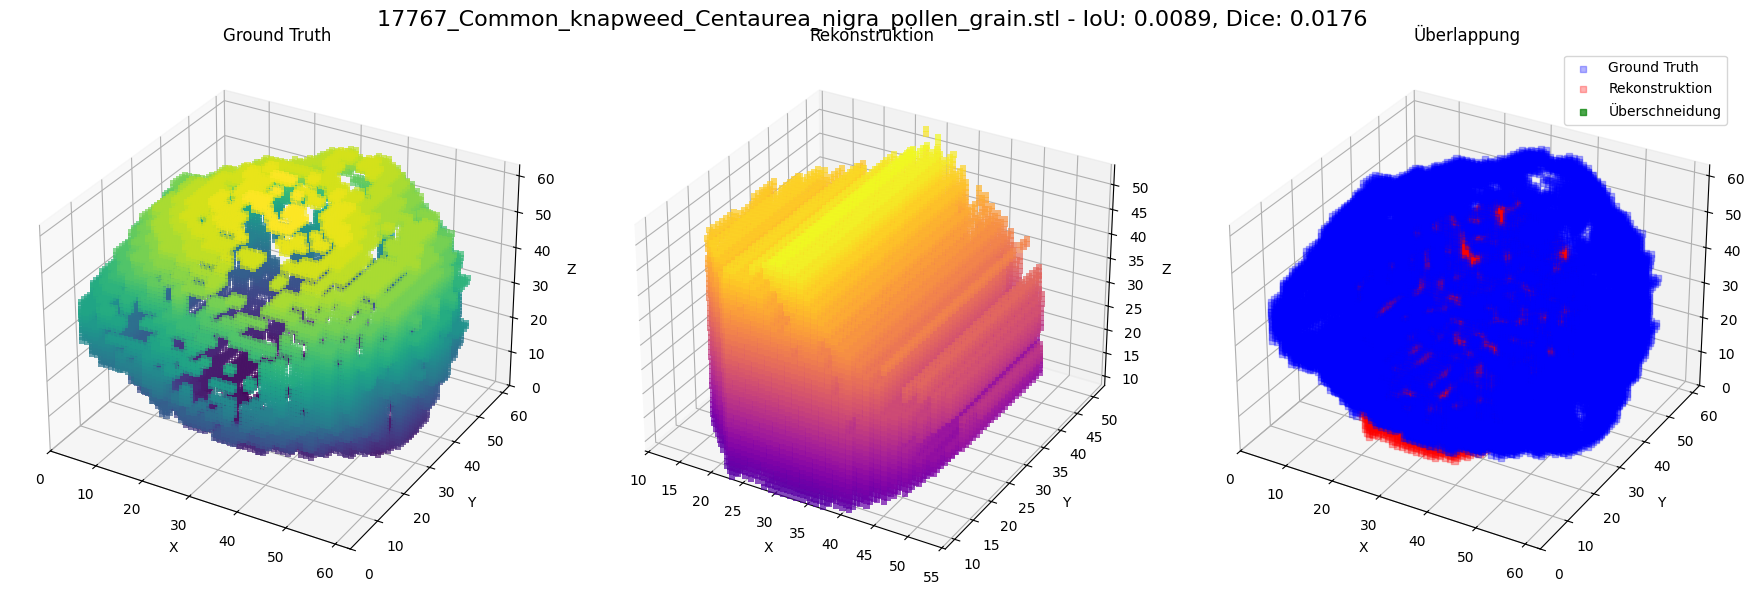

Evaluiere Modelle:   0%|          | 1/206 [00:20<1:08:41, 20.10s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17767_Common_knapweed_Centaurea_nigra_pollen_grain_vsi.stl gespeichert

Verarbeite 17775_Chive_Allium_schoenoprasum_pollen_grain.stl (2/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17775_Chive_Allium_schoenoprasum_pollen_grain.stl
Mesh loaded successfully: 79668 faces, 39836 vertices
Mesh volume: 3085.114876277135
Is watertight: True
Bounding box: [[10.98509979  9.72506046  0.198963  ]
 [28.69519997 36.45899963 17.72190094]]
Trying ray-based voxelization...
Voxelized shape: (19, 29, 19), filled voxels: 1243
Resizing voxel grid from (19, 29, 19) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 31613 filled voxels
  IoU: 0.0288, Dice: 0.0559, F1: 0.0559
  Precision: 0.1497, Recall: 0.0344
  Volumenverhältnis: 0.2297 (7262/31613 Voxel)


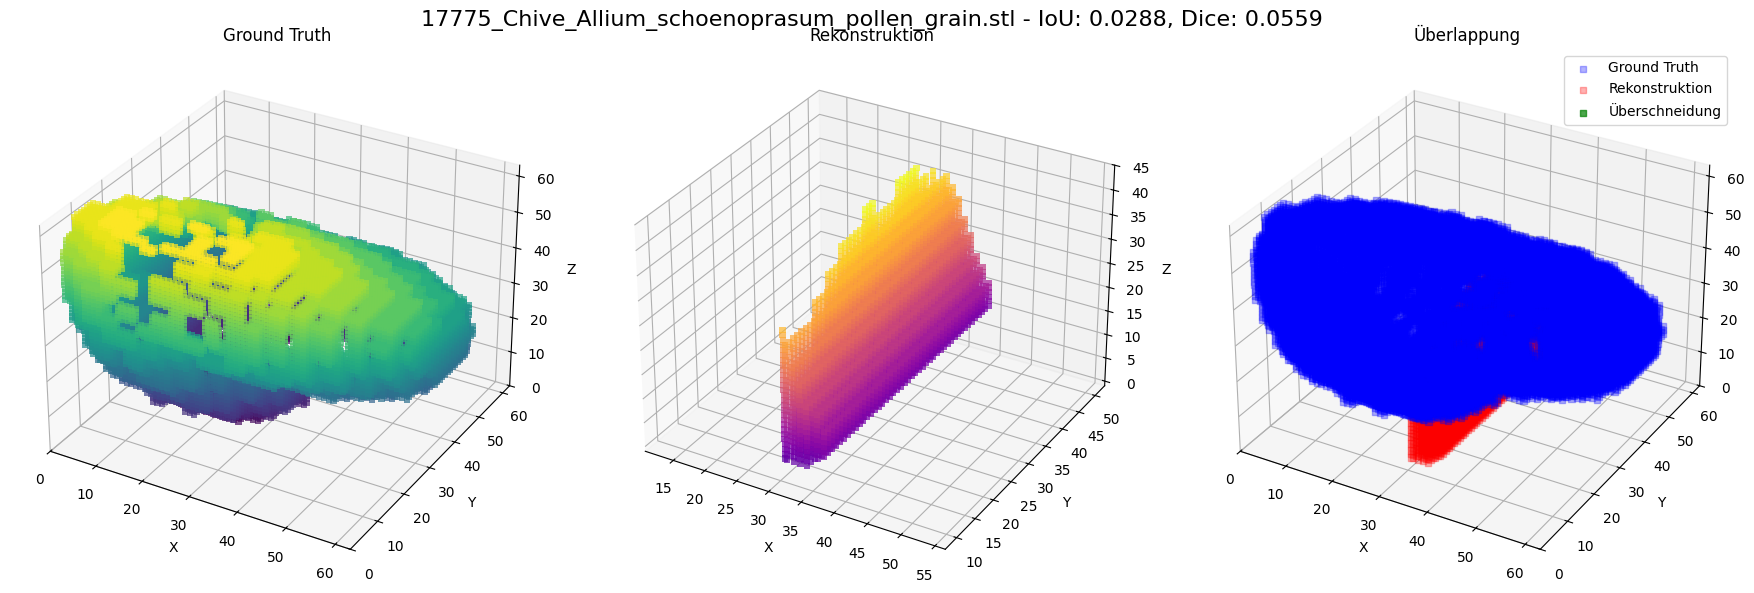

Evaluiere Modelle:   1%|          | 2/206 [00:22<33:19,  9.80s/it]  

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17775_Chive_Allium_schoenoprasum_pollen_grain_vsi.stl gespeichert

Verarbeite 17776_Sweet_alyssum_Lobularia_maritima_pollen_grain.stl (3/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17776_Sweet_alyssum_Lobularia_maritima_pollen_grain.stl
Mesh loaded successfully: 181272 faces, 90020 vertices
Mesh volume: 1659.4445744429966
Is watertight: False
Bounding box: [[13.37150002 16.89209938  1.45009995]
 [38.01139832 30.42079926 14.91619968]]
Mesh is not watertight, attempting repairs...
Trying ray-based voxelization...
Voxelized shape: (29, 16, 17), filled voxels: 2597
Resizing voxel grid from (29, 16, 17) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 95538 filled voxels
  IoU: 0.0242, Dice: 0.0473, F1: 0.0473
  Precision: 0.8193, Recall: 0.0243
  Volumenverhältnis: 0.0297 (2839/95538 Voxel)


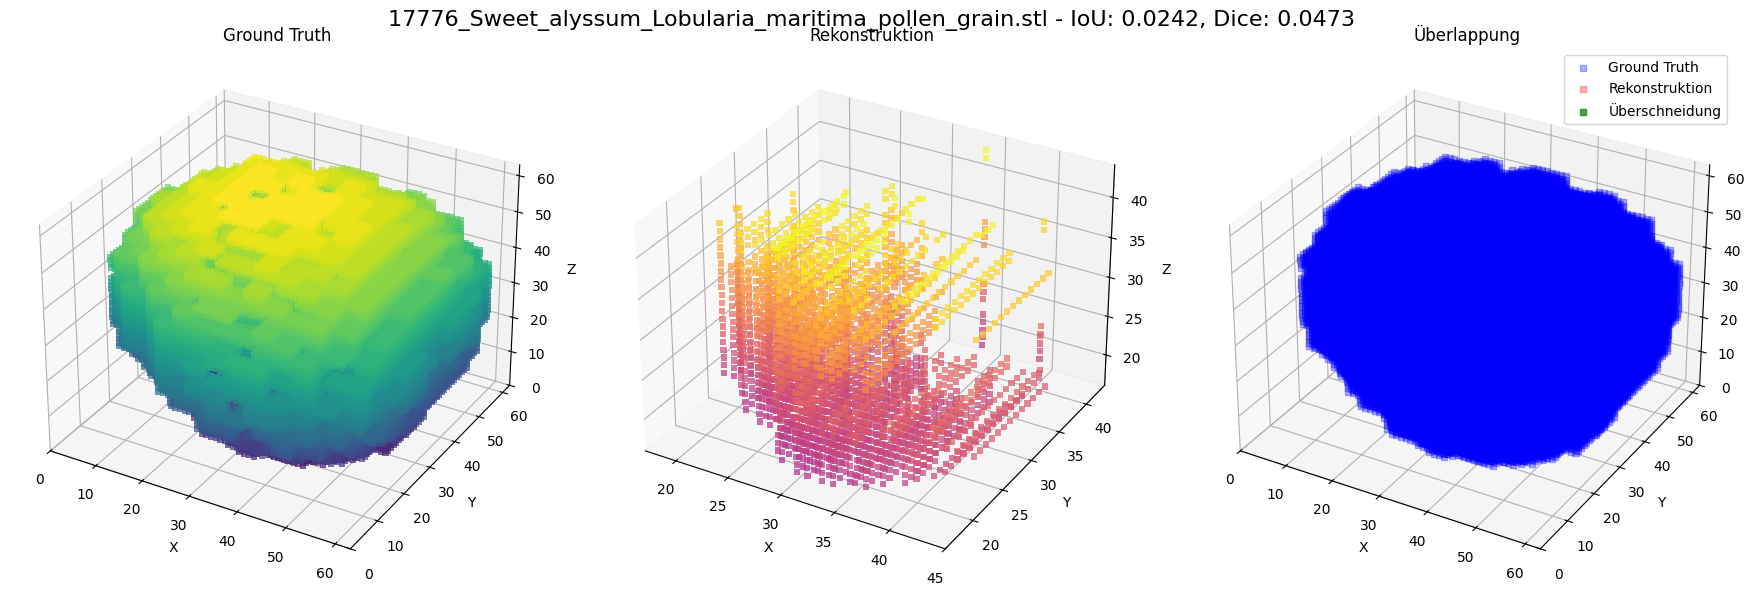

Evaluiere Modelle:   1%|▏         | 3/206 [00:29<28:47,  8.51s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17776_Sweet_alyssum_Lobularia_maritima_pollen_grain_vsi.stl gespeichert

Verarbeite 17777_Blackberry_Rubus_fruticosus_pollen_grain.stl (4/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17777_Blackberry_Rubus_fruticosus_pollen_grain.stl
Mesh loaded successfully: 163942 faces, 82007 vertices
Mesh volume: 9847.921052154668
Is watertight: True
Bounding box: [[11.12209988 15.82730007  1.98994994]
 [39.67490005 40.81890106 32.26150131]]
Trying ray-based voxelization...
Voxelized shape: (27, 24, 29), filled voxels: 2117
Resizing voxel grid from (27, 24, 29) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 30392 filled voxels
  IoU: 0.0299, Dice: 0.0581, F1: 0.0581
  Precision: 0.0669, Recall: 0.0514
  Volumenverhältnis: 0.7686 (23360/30392 Voxel)


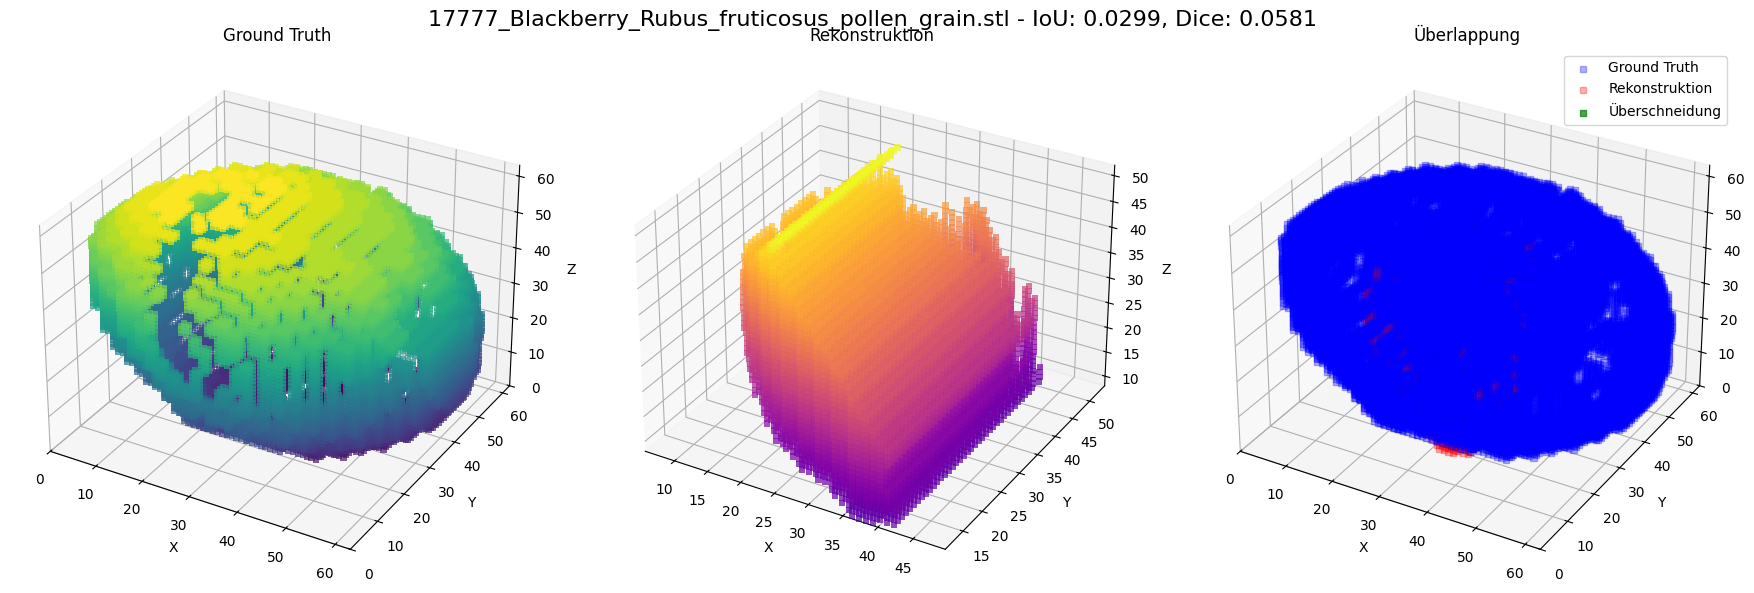

Evaluiere Modelle:   2%|▏         | 4/206 [00:35<25:10,  7.48s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17777_Blackberry_Rubus_fruticosus_pollen_grain_vsi.stl gespeichert

Verarbeite 17778_Willow_Salix_alba_pollen_grain.stl (5/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17778_Willow_Salix_alba_pollen_grain.stl
Mesh loaded successfully: 164768 faces, 82380 vertices
Mesh volume: 1564.6155310670738
Is watertight: True
Bounding box: [[ 6.47849989  8.09424019  1.95377004]
 [24.93050003 26.07220078 19.79140091]]
Trying ray-based voxelization...
Voxelized shape: (29, 29, 29), filled voxels: 3740
Resizing voxel grid from (29, 29, 29) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 41932 filled voxels
  IoU: 0.0400, Dice: 0.0770, F1: 0.0770
  Precision: 0.0938, Recall: 0.0653
  Volumenverhältnis: 0.6957 (29172/41932 Voxel)


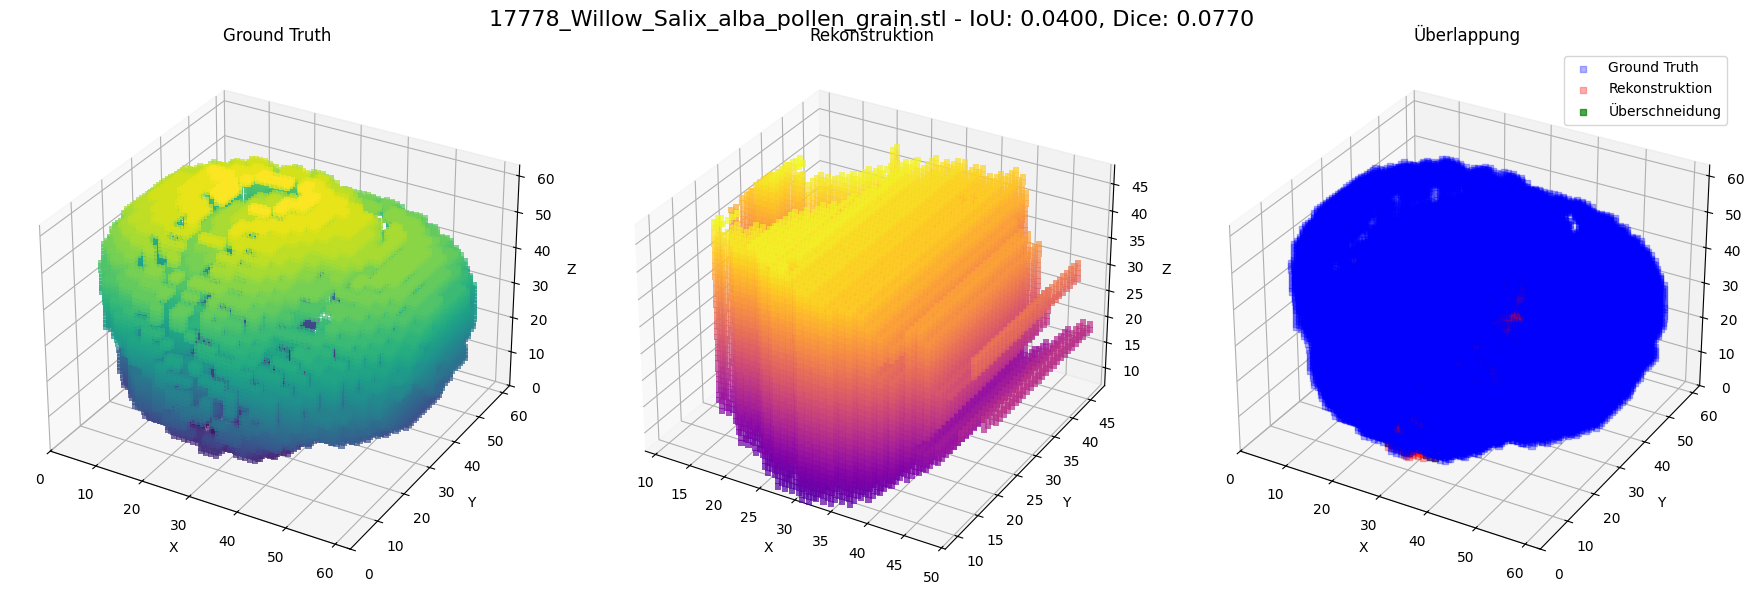

Evaluiere Modelle:   2%|▏         | 5/206 [00:44<27:04,  8.08s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17778_Willow_Salix_alba_pollen_grain_vsi.stl gespeichert

Verarbeite 17779_Strawberry_Fragaria_ananassa_pollen_grain.stl (6/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17779_Strawberry_Fragaria_ananassa_pollen_grain.stl
Mesh loaded successfully: 165232 faces, 82614 vertices
Mesh volume: 3764.594120991105
Is watertight: True
Bounding box: [[ 2.98723006  7.32780981  1.71298003]
 [32.54669952 31.38369942 26.42869949]]
Trying ray-based voxelization...
Voxelized shape: (29, 24, 25), filled voxels: 3341
Resizing voxel grid from (29, 24, 25) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 52755 filled voxels
  IoU: 0.0279, Dice: 0.0542, F1: 0.0542
  Precision: 0.0902, Recall: 0.0388
  Volumenverhältnis: 0.4299 (22681/52755 Voxel)


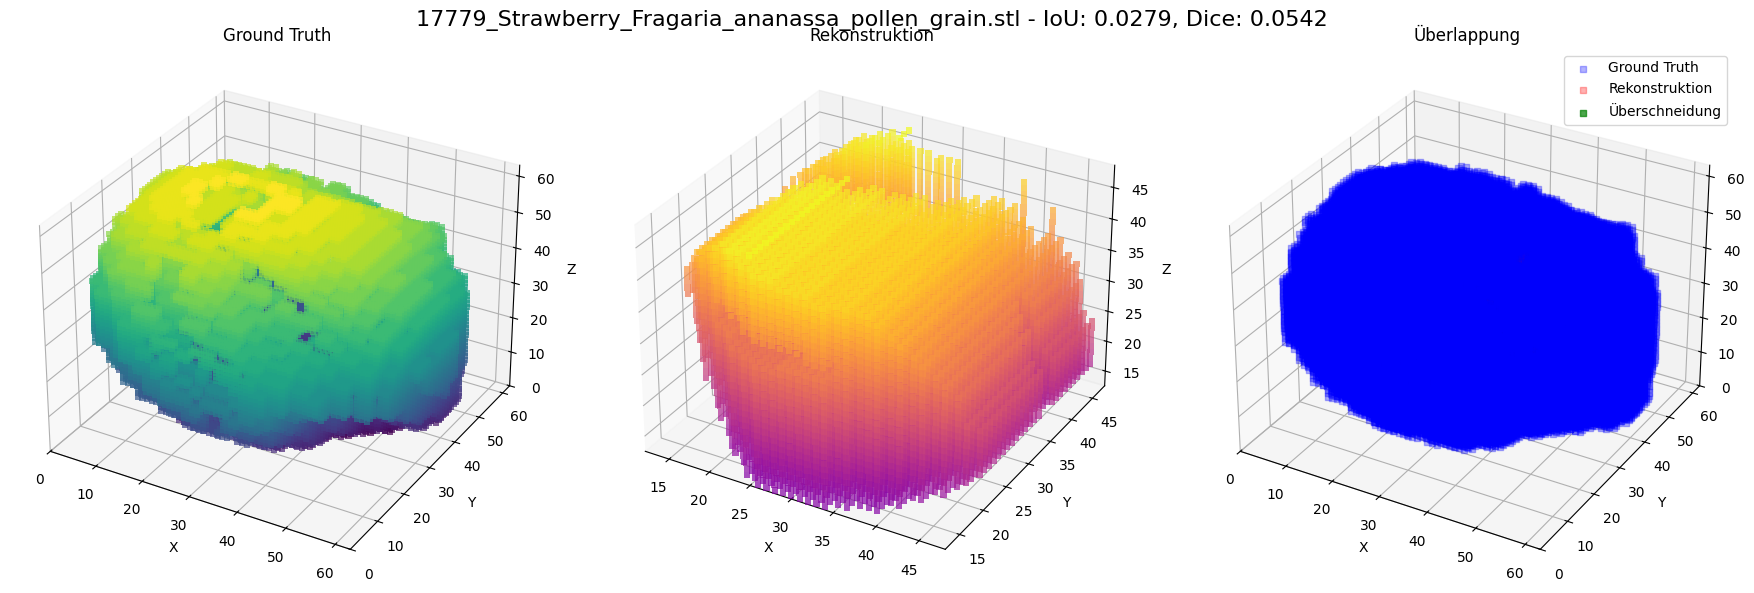

Evaluiere Modelle:   3%|▎         | 6/206 [01:05<40:55, 12.28s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17779_Strawberry_Fragaria_ananassa_pollen_grain_vsi.stl gespeichert

Verarbeite 17781_Common_thyme_Thymus_vulgaris_pollen_grain.stl (7/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17781_Common_thyme_Thymus_vulgaris_pollen_grain.stl
Mesh loaded successfully: 167096 faces, 83564 vertices
Mesh volume: 16075.079970714403
Is watertight: True
Bounding box: [[16.38599968 17.82760048  1.52180004]
 [48.57550049 52.20930099 30.83589935]]
Trying ray-based voxelization...
Voxelized shape: (27, 29, 25), filled voxels: 2155
Resizing voxel grid from (27, 29, 25) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 29474 filled voxels
  IoU: 0.0122, Dice: 0.0242, F1: 0.0242
  Precision: 0.0299, Recall: 0.0203
  Volumenverhältnis: 0.6769 (19952/29474 Voxel)


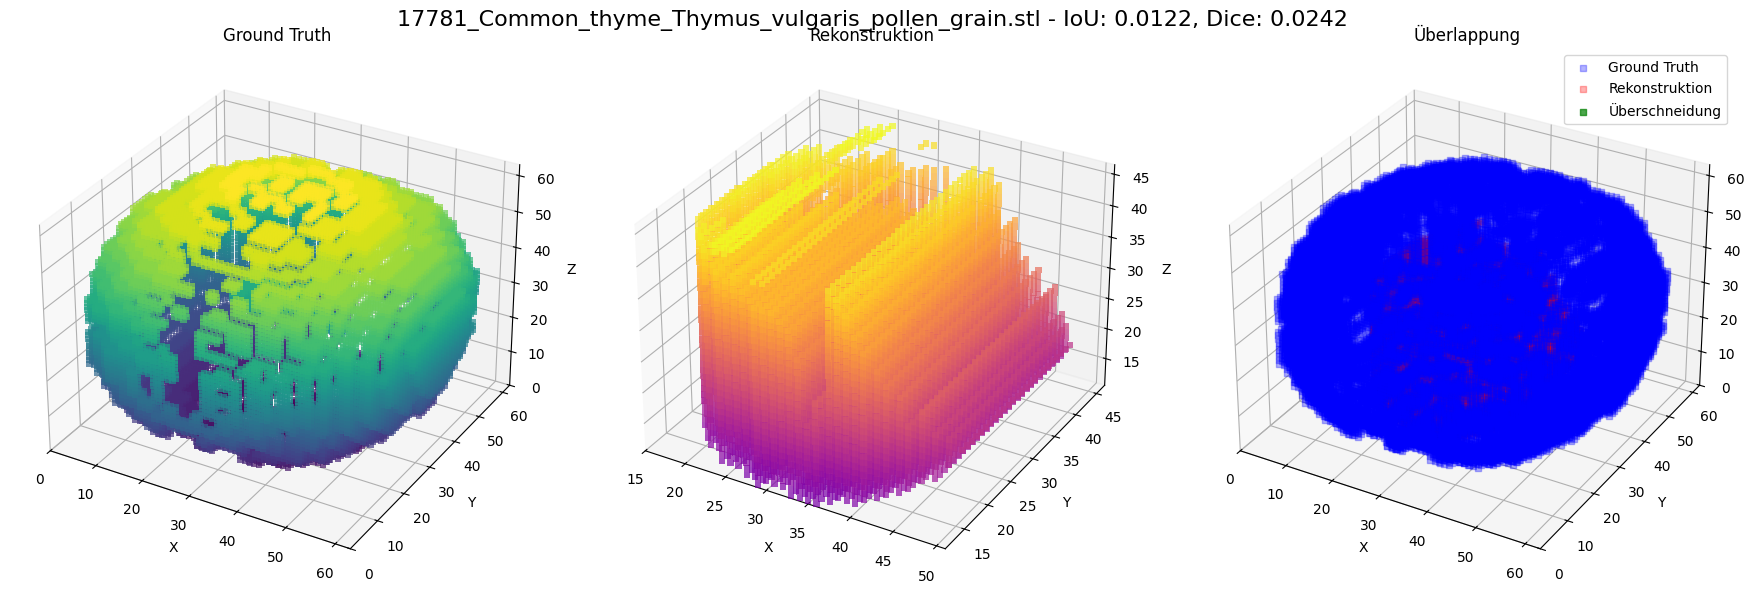

Evaluiere Modelle:   3%|▎         | 7/206 [01:10<32:59,  9.95s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17781_Common_thyme_Thymus_vulgaris_pollen_grain_vsi.stl gespeichert

Verarbeite 17782_Golden-ray_lily_Lilium_auratum_pollen_grain.stl (8/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17782_Golden-ray_lily_Lilium_auratum_pollen_grain.stl
Mesh loaded successfully: 167776 faces, 83865 vertices
Mesh volume: 99000.67008073349
Is watertight: False
Bounding box: [[10.05099964  1.63855004  0.109713  ]
 [69.85839844 77.4332962  40.87979889]]
Mesh is not watertight, attempting repairs...
Trying ray-based voxelization...
Voxelized shape: (23, 29, 17), filled voxels: 2104
Resizing voxel grid from (23, 29, 17) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 52156 filled voxels
  IoU: 0.0258, Dice: 0.0503, F1: 0.0503
  Precision: 0.1085, Recall: 0.0328
  Volumenverhältnis: 0.3021 (15757/52156 Voxel)


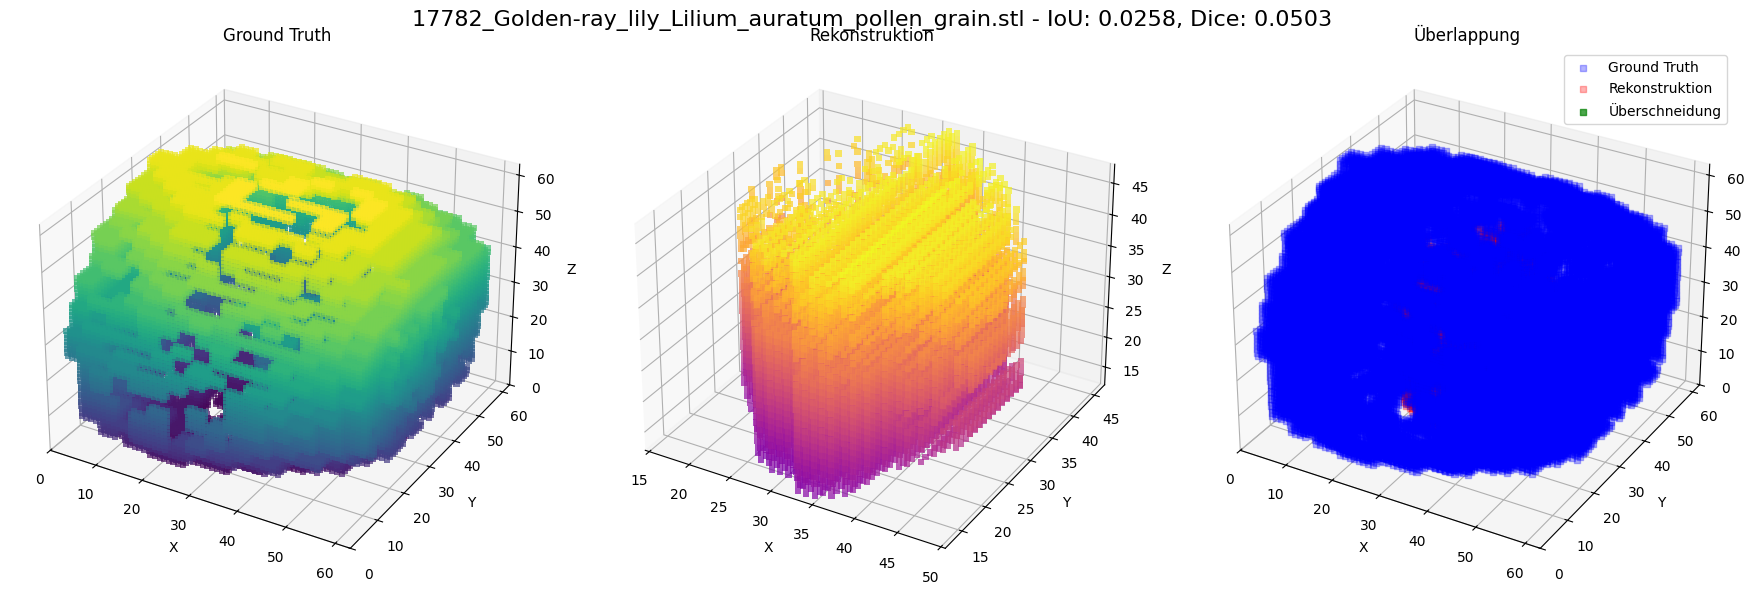

Evaluiere Modelle:   4%|▍         | 8/206 [01:24<37:41, 11.42s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17782_Golden-ray_lily_Lilium_auratum_pollen_grain_vsi.stl gespeichert

Verarbeite 17783_Ribwort_plantain_Plantago_lanceolata_pollen_grain.stl (9/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17783_Ribwort_plantain_Plantago_lanceolata_pollen_grain.stl
Mesh loaded successfully: 158918 faces, 79525 vertices
Mesh volume: 9351.55605017589
Is watertight: True
Bounding box: [[ 6.90115023  5.95558977  0.285027  ]
 [32.44630051 33.5943985  26.61700058]]
Trying ray-based voxelization...
Voxelized shape: (27, 29, 29), filled voxels: 2184
Resizing voxel grid from (27, 29, 29) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 25739 filled voxels
  IoU: 0.0008, Dice: 0.0016, F1: 0.0016
  Precision: 0.0016, Recall: 0.0016
  Volumenverhältnis: 1.0127 (26067/25739 Voxel)


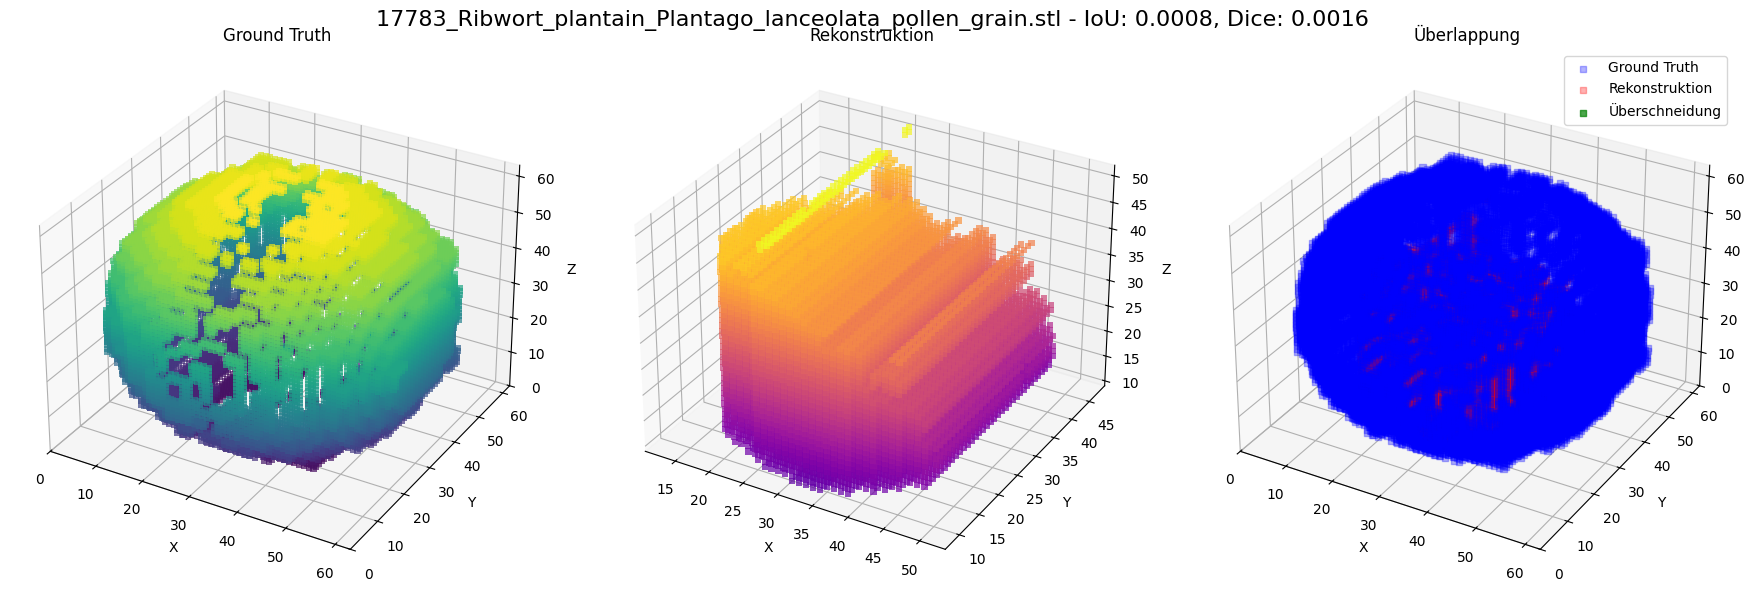

Evaluiere Modelle:   4%|▍         | 9/206 [01:30<31:58,  9.74s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17783_Ribwort_plantain_Plantago_lanceolata_pollen_grain_vsi.stl gespeichert

Verarbeite 17784_Rose_Rosa_sp_pollen_grain.stl (10/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17784_Rose_Rosa_sp_pollen_grain.stl
Mesh loaded successfully: 160896 faces, 80450 vertices
Mesh volume: 6322.74757039456
Is watertight: True
Bounding box: [[17.7798996  13.94569969  1.54525995]
 [41.31980133 44.94540024 21.16069984]]
Trying ray-based voxelization...
Voxelized shape: (23, 29, 19), filled voxels: 1664
Resizing voxel grid from (23, 29, 19) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 35920 filled voxels
  IoU: 0.0116, Dice: 0.0229, F1: 0.0229
  Precision: 0.0556, Recall: 0.0144
  Volumenverhältnis: 0.2589 (9298/35920 Voxel)


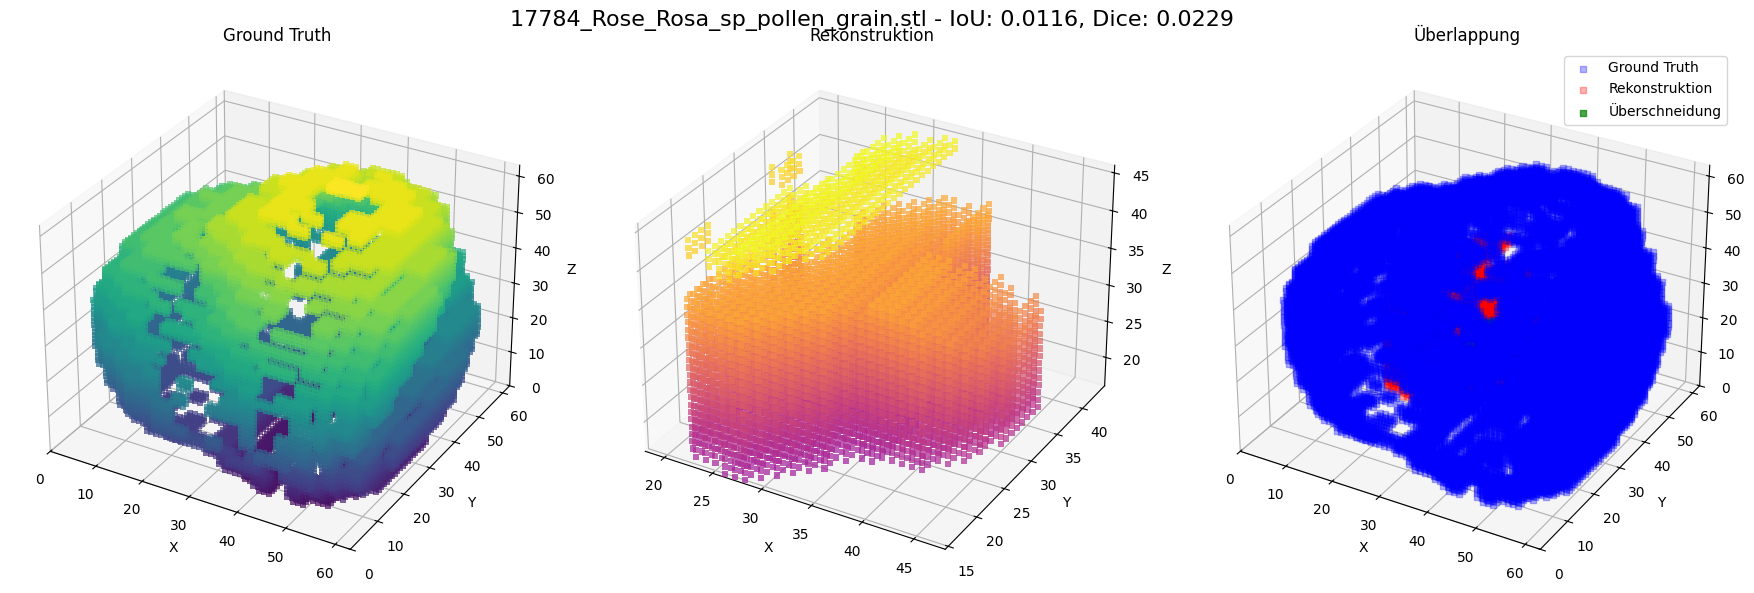

Evaluiere Modelle:   5%|▍         | 10/206 [01:34<25:37,  7.84s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17784_Rose_Rosa_sp_pollen_grain_vsi.stl gespeichert

Verarbeite 17785_Hedge_bindweed_Calystegia_sepium_pollen_grain.stl (11/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17785_Hedge_bindweed_Calystegia_sepium_pollen_grain.stl
Mesh loaded successfully: 197122 faces, 98563 vertices
Mesh volume: 205130.03435063592
Is watertight: True
Bounding box: [[-17.01989937 -22.61109924 -52.12400055]
 [ 57.86149979  53.05419922  19.18359947]]
Trying ray-based voxelization...
Voxelized shape: (29, 29, 29), filled voxels: 2439
Resizing voxel grid from (29, 29, 29) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 26870 filled voxels
  IoU: 0.0010, Dice: 0.0020, F1: 0.0020
  Precision: 0.0017, Recall: 0.0022
  Volumenverhältnis: 1.2880 (34608/26870 Voxel)


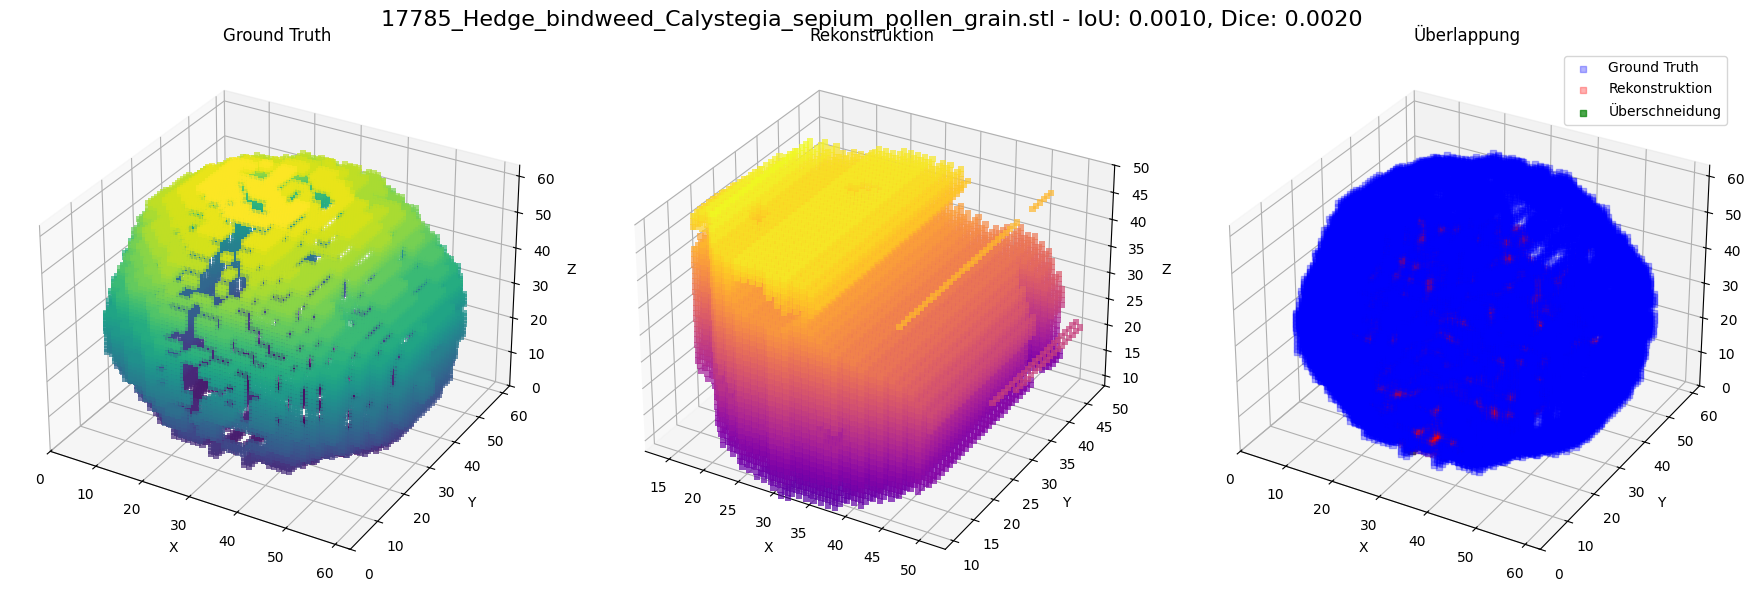

Evaluiere Modelle:   5%|▌         | 11/206 [01:41<25:08,  7.74s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17785_Hedge_bindweed_Calystegia_sepium_pollen_grain_vsi.stl gespeichert

Verarbeite 17786_Poppy_Papaver_sp_pollen_grain.stl (12/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17786_Poppy_Papaver_sp_pollen_grain.stl
Mesh loaded successfully: 161426 faces, 80745 vertices
Mesh volume: 18351.36421942066
Is watertight: False
Bounding box: [[13.71940041 14.25409985  1.27520001]
 [46.70980072 47.48709869 34.02539825]]
Mesh is not watertight, attempting repairs...
Trying ray-based voxelization...
Voxelized shape: (29, 29, 29), filled voxels: 2932
Resizing voxel grid from (29, 29, 29) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 32128 filled voxels
  IoU: 0.0414, Dice: 0.0795, F1: 0.0795
  Precision: 0.0815, Recall: 0.0776
  Volumenverhältnis: 0.9519 (30584/32128 Voxel)


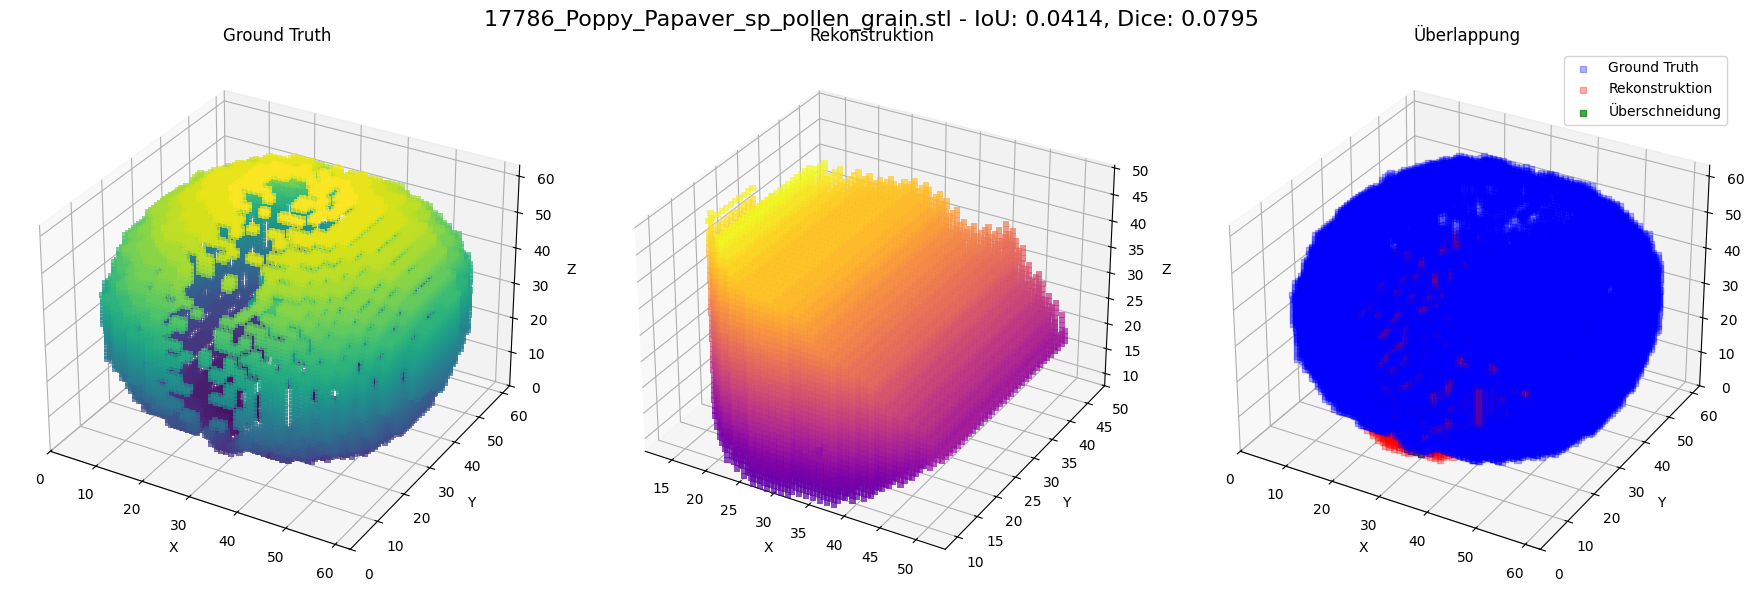

Evaluiere Modelle:   6%|▌         | 12/206 [01:49<24:58,  7.73s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17786_Poppy_Papaver_sp_pollen_grain_vsi.stl gespeichert

Verarbeite 17787_Yellow_iris_Iris_pseudacorus_pollen_grain.stl (13/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17787_Yellow_iris_Iris_pseudacorus_pollen_grain.stl
Mesh loaded successfully: 171812 faces, 84823 vertices
Mesh volume: 174297.39484516325
Is watertight: False
Bounding box: [[ 27.52540016  29.34119987   2.38579988]
 [114.21399689 116.06999969  87.85359955]]
Mesh is not watertight, attempting repairs...
Trying ray-based voxelization...
Voxelized shape: (29, 29, 29), filled voxels: 7036
Resizing voxel grid from (29, 29, 29) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 79000 filled voxels
  IoU: 0.1663, Dice: 0.2852, F1: 0.2852
  Precision: 0.5321, Recall: 0.1948
  Volumenverhältnis: 0.3662 (28928/79000 Voxel)


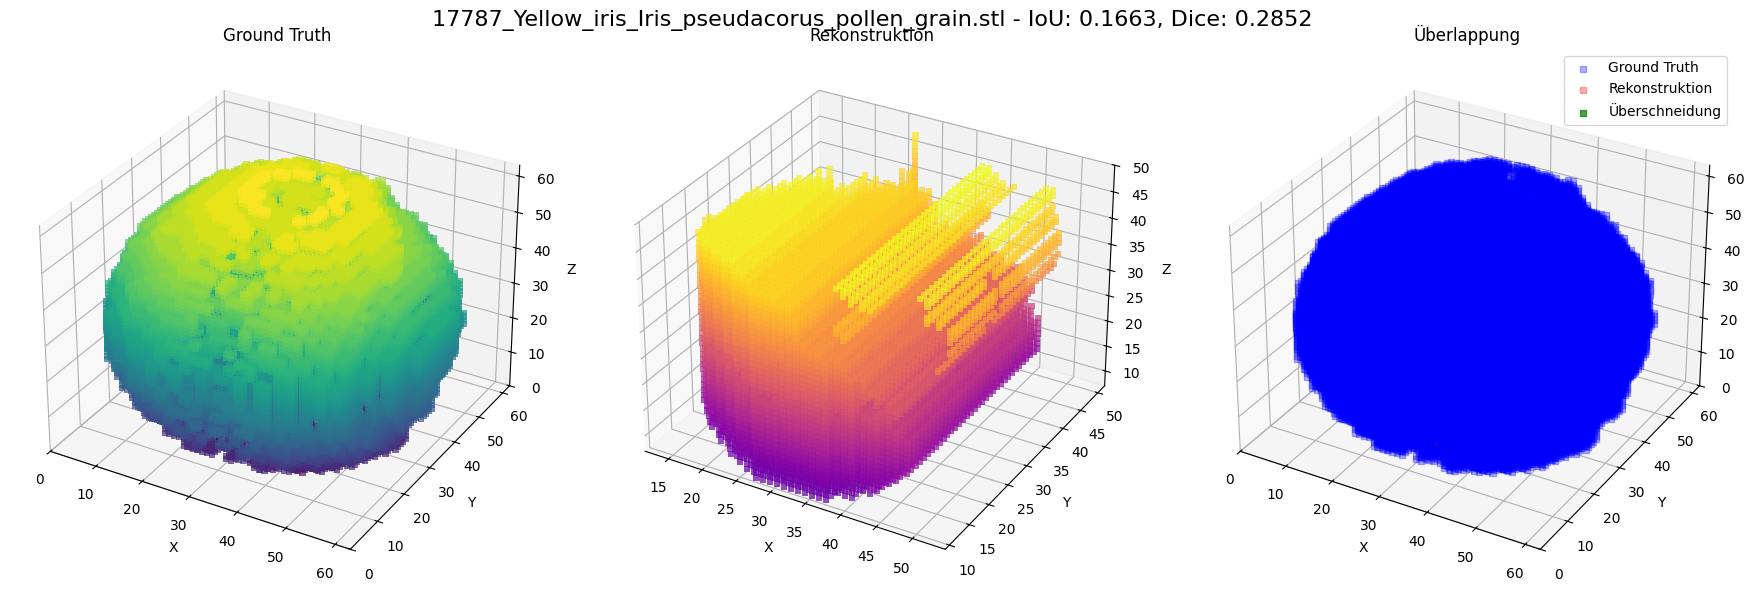

Evaluiere Modelle:   6%|▋         | 13/206 [02:27<53:46, 16.72s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17787_Yellow_iris_Iris_pseudacorus_pollen_grain_vsi.stl gespeichert

Verarbeite 17788_Gorse_Ulex_europaeus_pollen_grain.stl (14/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17788_Gorse_Ulex_europaeus_pollen_grain.stl
Mesh loaded successfully: 175934 faces, 87969 vertices
Mesh volume: 11330.416690202886
Is watertight: True
Bounding box: [[ 8.60972023 12.18529987  0.67985499]
 [38.04980087 42.23009872 27.42350006]]
Trying ray-based voxelization...
Voxelized shape: (29, 29, 27), filled voxels: 2163
Resizing voxel grid from (29, 29, 27) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 25667 filled voxels
  IoU: 0.0029, Dice: 0.0058, F1: 0.0058
  Precision: 0.0062, Recall: 0.0055
  Volumenverhältnis: 0.8848 (22710/25667 Voxel)


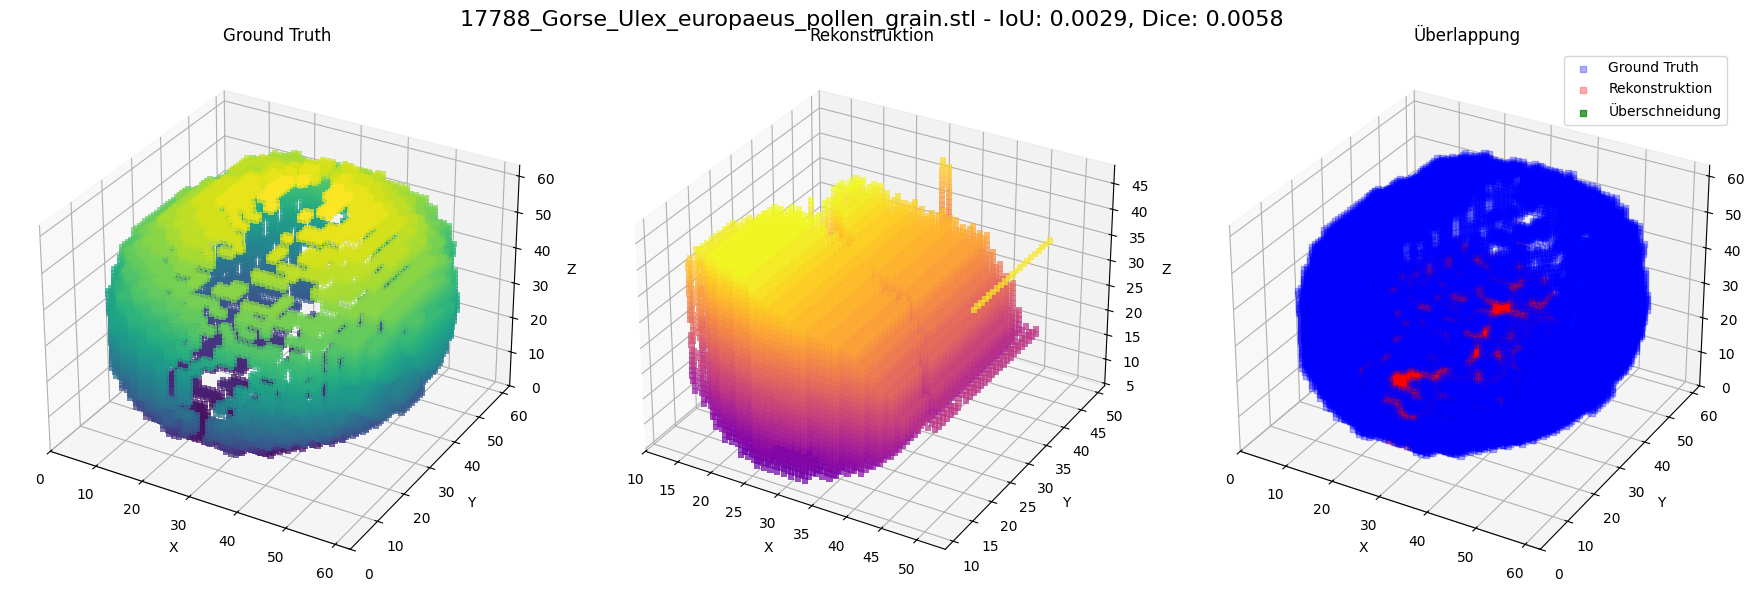

Evaluiere Modelle:   7%|▋         | 14/206 [02:32<42:24, 13.25s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17788_Gorse_Ulex_europaeus_pollen_grain_vsi.stl gespeichert

Verarbeite 17789_Common_foxglove_Digitalis_purpurea_pollen_grain.stl (15/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17789_Common_foxglove_Digitalis_purpurea_pollen_grain.stl
Mesh loaded successfully: 164330 faces, 82151 vertices
Mesh volume: 12396.172831866623
Is watertight: False
Bounding box: [[18.15670013 18.90600014  1.07143998]
 [47.84740067 49.69459915 30.26259995]]
Mesh is not watertight, attempting repairs...
Trying ray-based voxelization...
Voxelized shape: (28, 29, 29), filled voxels: 3586
Resizing voxel grid from (28, 29, 29) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 41379 filled voxels
  IoU: 0.1443, Dice: 0.2523, F1: 0.2523
  Precision: 0.2806, Recall: 0.2291
  Volumenverhältnis: 0.8163 (33776/41379 Voxel)


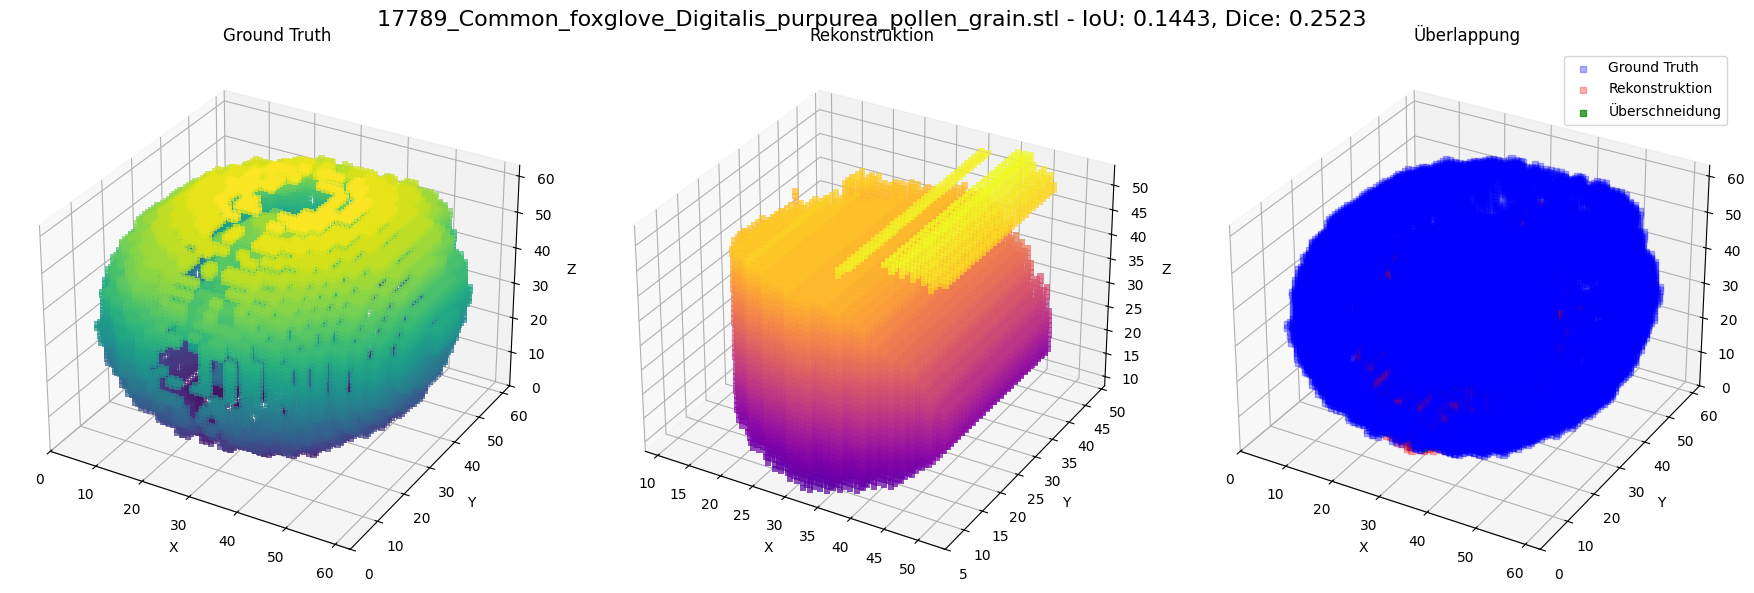

Evaluiere Modelle:   7%|▋         | 15/206 [02:42<39:32, 12.42s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17789_Common_foxglove_Digitalis_purpurea_pollen_grain_vsi.stl gespeichert

Verarbeite 17790_Black_elderberry_Sambucus_nigra_pollen_grain.stl (16/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17790_Black_elderberry_Sambucus_nigra_pollen_grain.stl
Mesh loaded successfully: 181610 faces, 90801 vertices
Mesh volume: 1956.5462807043396
Is watertight: True
Bounding box: [[ 7.29568005 12.12549973  1.07879996]
 [32.07490158 29.22599983 13.71800041]]
Trying ray-based voxelization...
Voxelized shape: (29, 21, 15), filled voxels: 2056
Resizing voxel grid from (29, 21, 15) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 62675 filled voxels
  IoU: 0.0043, Dice: 0.0086, F1: 0.0086
  Precision: 0.1741, Recall: 0.0044
  Volumenverhältnis: 0.0252 (1580/62675 Voxel)


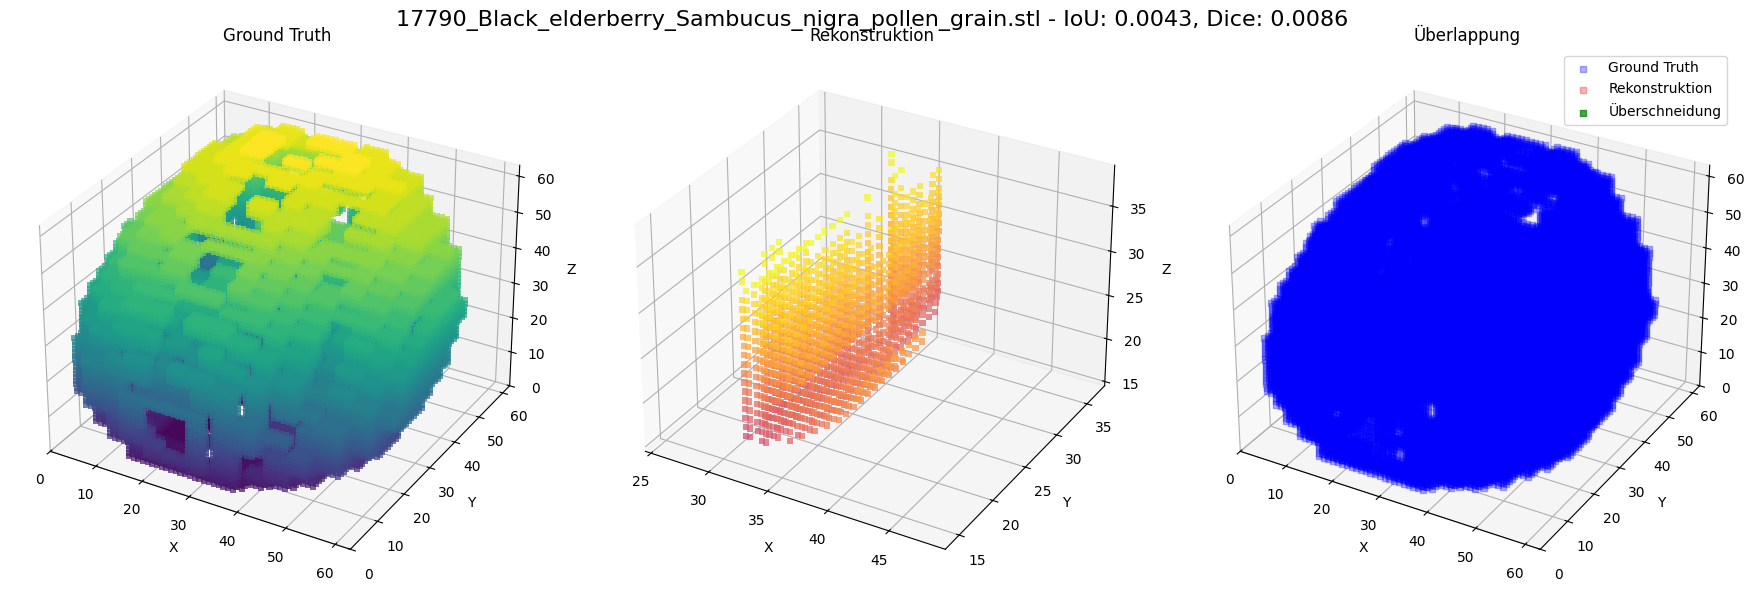

Evaluiere Modelle:   8%|▊         | 16/206 [02:46<31:00,  9.79s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17790_Black_elderberry_Sambucus_nigra_pollen_grain_vsi.stl gespeichert

Verarbeite 17791_Common_camellia_Camellia_japonica_pollen_grain.stl (17/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17791_Common_camellia_Camellia_japonica_pollen_grain.stl
Mesh loaded successfully: 183076 faces, 91529 vertices
Mesh volume: 25297.467404370498
Is watertight: False
Bounding box: [[ 7.64513016  9.39116955  0.115095  ]
 [57.36880112 63.67630005 44.80260086]]
Mesh is not watertight, attempting repairs...
Trying ray-based voxelization...
Voxelized shape: (27, 29, 25), filled voxels: 3700
Resizing voxel grid from (27, 29, 25) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 51793 filled voxels
  IoU: 0.0055, Dice: 0.0109, F1: 0.0109
  Precision: 0.0164, Recall: 0.0081
  Volumenverhältnis: 0.4932 (25545/51793 Voxel)


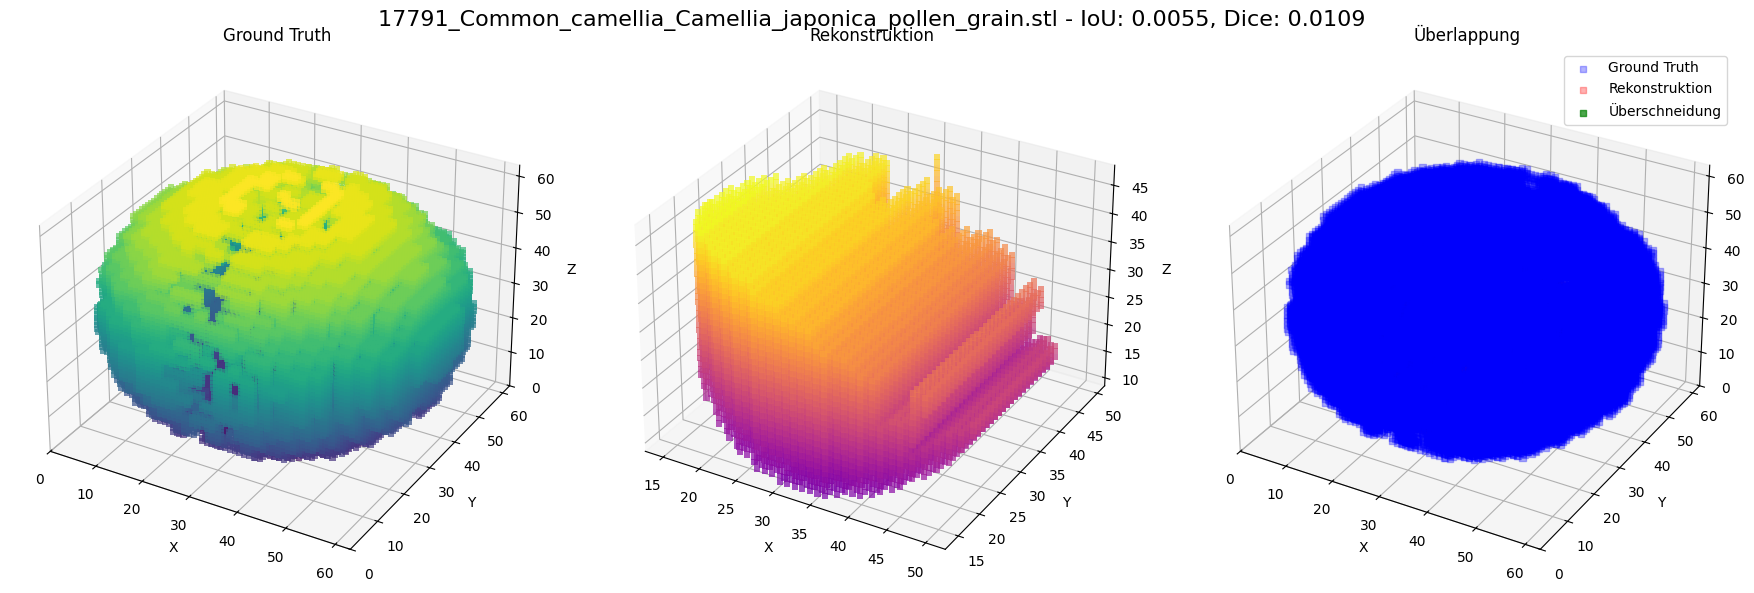

Evaluiere Modelle:   8%|▊         | 17/206 [03:08<42:32, 13.50s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17791_Common_camellia_Camellia_japonica_pollen_grain_vsi.stl gespeichert

Verarbeite 17792_Crimson_bottlebrush_Callistemon_citrinus_pollen_grain.stl (18/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17792_Crimson_bottlebrush_Callistemon_citrinus_pollen_grain.stl
Mesh loaded successfully: 187168 faces, 93588 vertices
Mesh volume: 1900.8182707533035
Is watertight: True
Bounding box: [[16.32119942 16.57419968  2.31113005]
 [37.01100159 38.36640167 19.74790001]]
Trying ray-based voxelization...
Voxelized shape: (28, 29, 25), filled voxels: 3285
Resizing voxel grid from (28, 29, 25) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 44518 filled voxels
  IoU: 0.0371, Dice: 0.0716, F1: 0.0716
  Precision: 0.0866, Recall: 0.0611
  Volumenverhältnis: 0.7047 (31372/44518 Voxel)


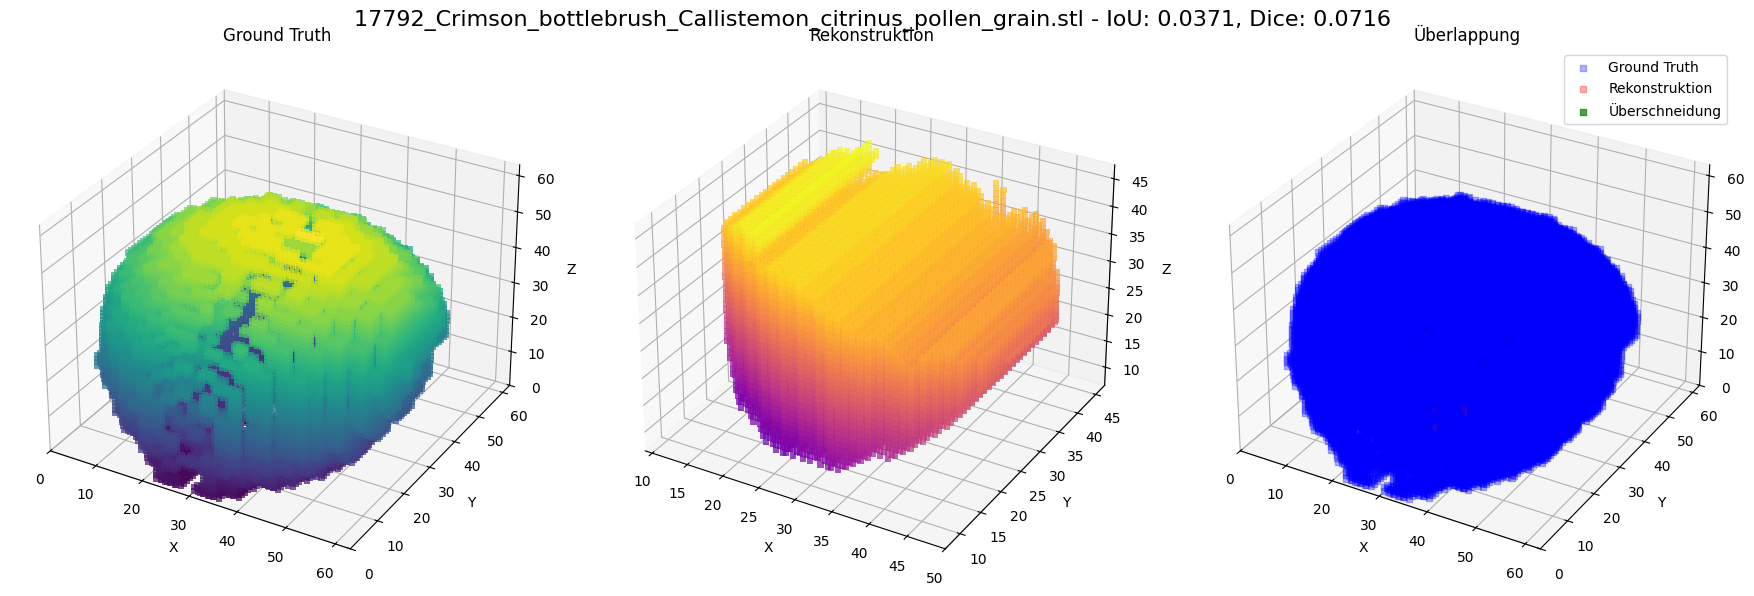

Evaluiere Modelle:   9%|▊         | 18/206 [03:32<51:49, 16.54s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17792_Crimson_bottlebrush_Callistemon_citrinus_pollen_grain_vsi.stl gespeichert

Verarbeite 17793_Cabbage_palm_Cordyline_australis_pollen_grain.stl (19/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17793_Cabbage_palm_Cordyline_australis_pollen_grain.stl
Mesh loaded successfully: 183808 faces, 92076 vertices
Mesh volume: 6766.4224675495725
Is watertight: True
Bounding box: [[15.43560028 12.24979973  1.49706995]
 [45.25899887 47.53590012 16.14959908]]
Trying ray-based voxelization...
Voxelized shape: (25, 29, 13), filled voxels: 1869
Resizing voxel grid from (25, 29, 13) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 54836 filled voxels
  IoU: 0.0079, Dice: 0.0157, F1: 0.0157
  Precision: 0.2386, Recall: 0.0081
  Volumenverhältnis: 0.0340 (1865/54836 Voxel)


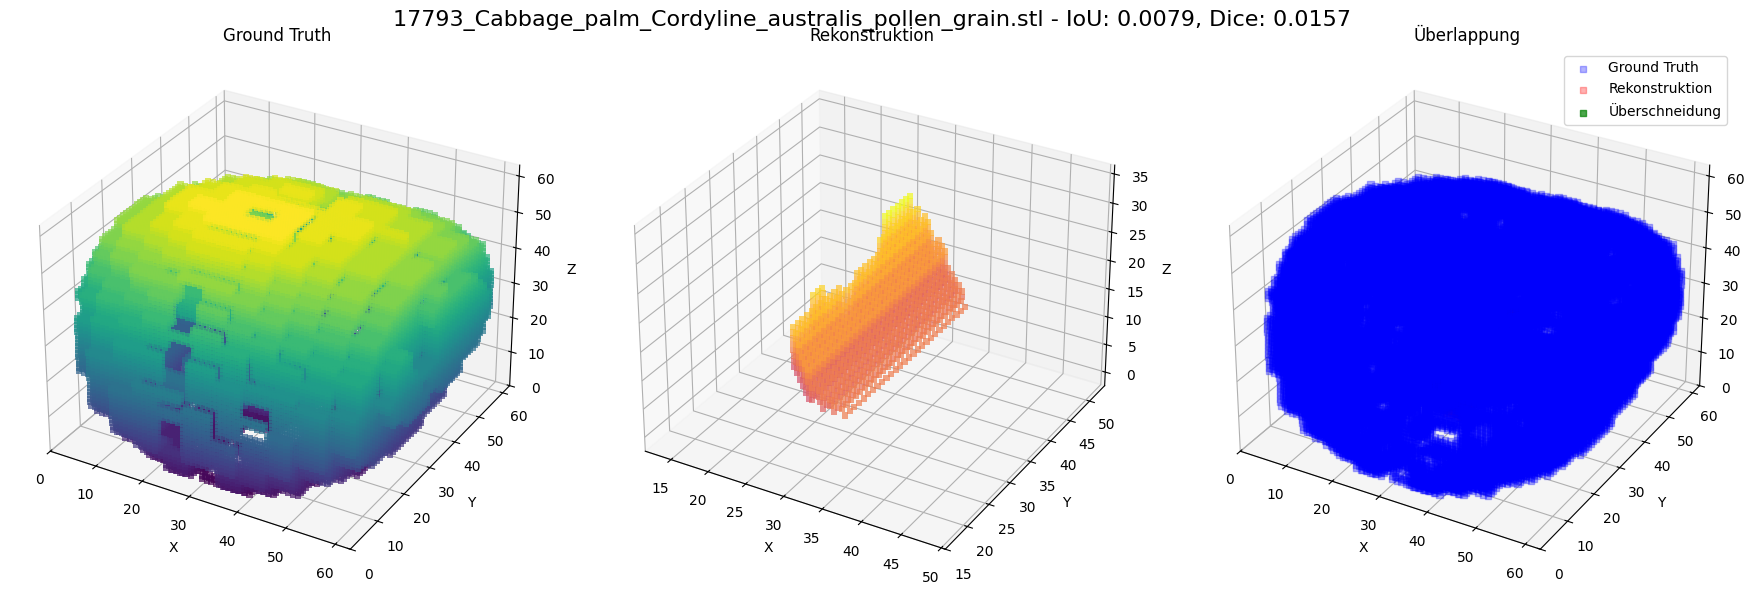

Evaluiere Modelle:   9%|▉         | 19/206 [03:35<39:25, 12.65s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17793_Cabbage_palm_Cordyline_australis_pollen_grain_vsi.stl gespeichert

Verarbeite 17794_Butterfly_bush_Buddleja_davidii_pollen_grain.stl (20/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17794_Butterfly_bush_Buddleja_davidii_pollen_grain.stl
Mesh loaded successfully: 164210 faces, 82123 vertices
Mesh volume: 11513.103924436176
Is watertight: True
Bounding box: [[17.11370087 19.14970016  1.21990001]
 [46.14609909 50.31069946 28.12989998]]
Trying ray-based voxelization...
Voxelized shape: (27, 29, 25), filled voxels: 2136
Resizing voxel grid from (27, 29, 25) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 29186 filled voxels
  IoU: 0.0006, Dice: 0.0013, F1: 0.0013
  Precision: 0.0016, Recall: 0.0011
  Volumenverhältnis: 0.6917 (20188/29186 Voxel)


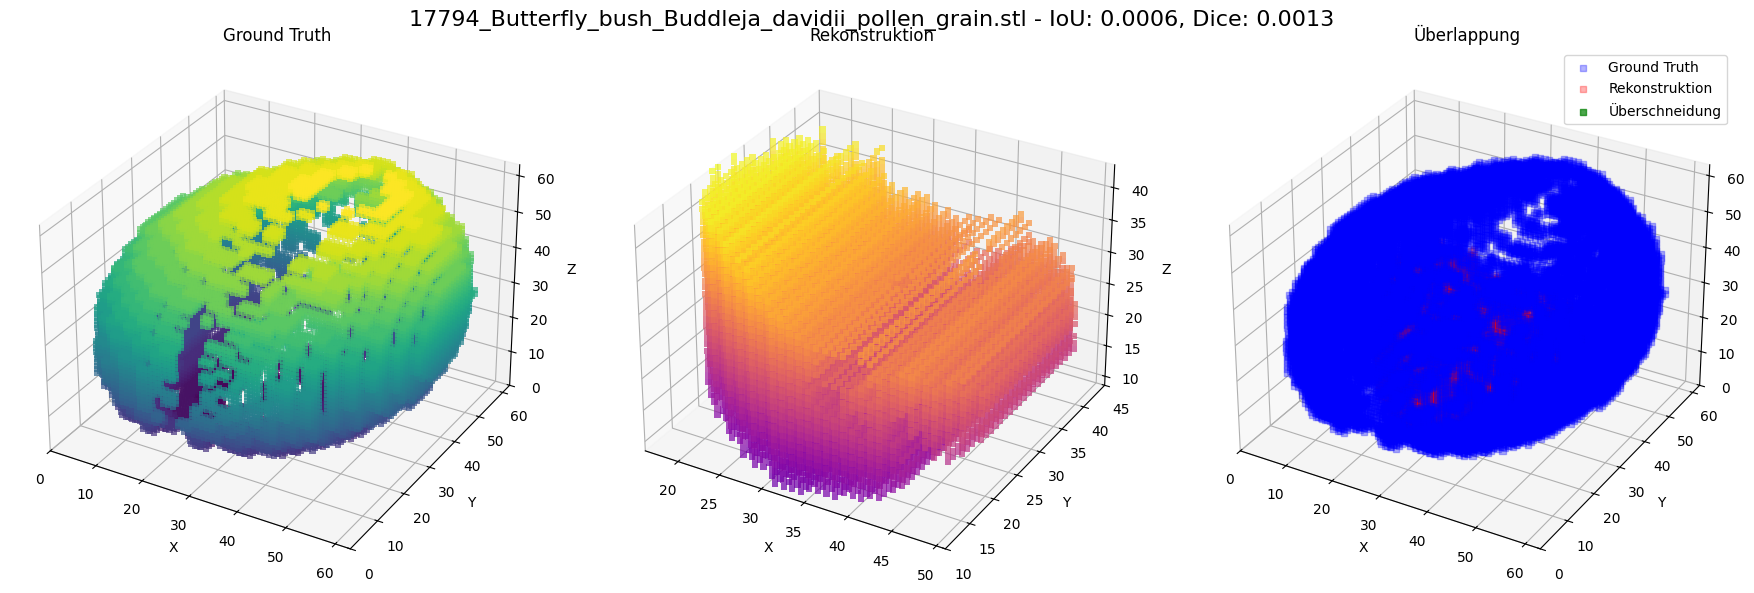

Evaluiere Modelle:  10%|▉         | 20/206 [03:41<32:23, 10.45s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17794_Butterfly_bush_Buddleja_davidii_pollen_grain_vsi.stl gespeichert

Verarbeite 17795_Common_heather_Calluna_vulgaris_pollen_grain.stl (21/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17795_Common_heather_Calluna_vulgaris_pollen_grain.stl
Mesh loaded successfully: 192576 faces, 96296 vertices
Mesh volume: 8766.209803786938
Is watertight: False
Bounding box: [[10.98009968 11.48130035  1.57125998]
 [45.72779846 44.68259811 33.51200104]]
Mesh is not watertight, attempting repairs...
Trying ray-based voxelization...
Voxelized shape: (29, 28, 27), filled voxels: 4440
Resizing voxel grid from (29, 28, 27) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 55186 filled voxels
  IoU: 0.0748, Dice: 0.1393, F1: 0.1393
  Precision: 0.2104, Recall: 0.1041
  Volumenverhältnis: 0.4948 (27306/55186 Voxel)


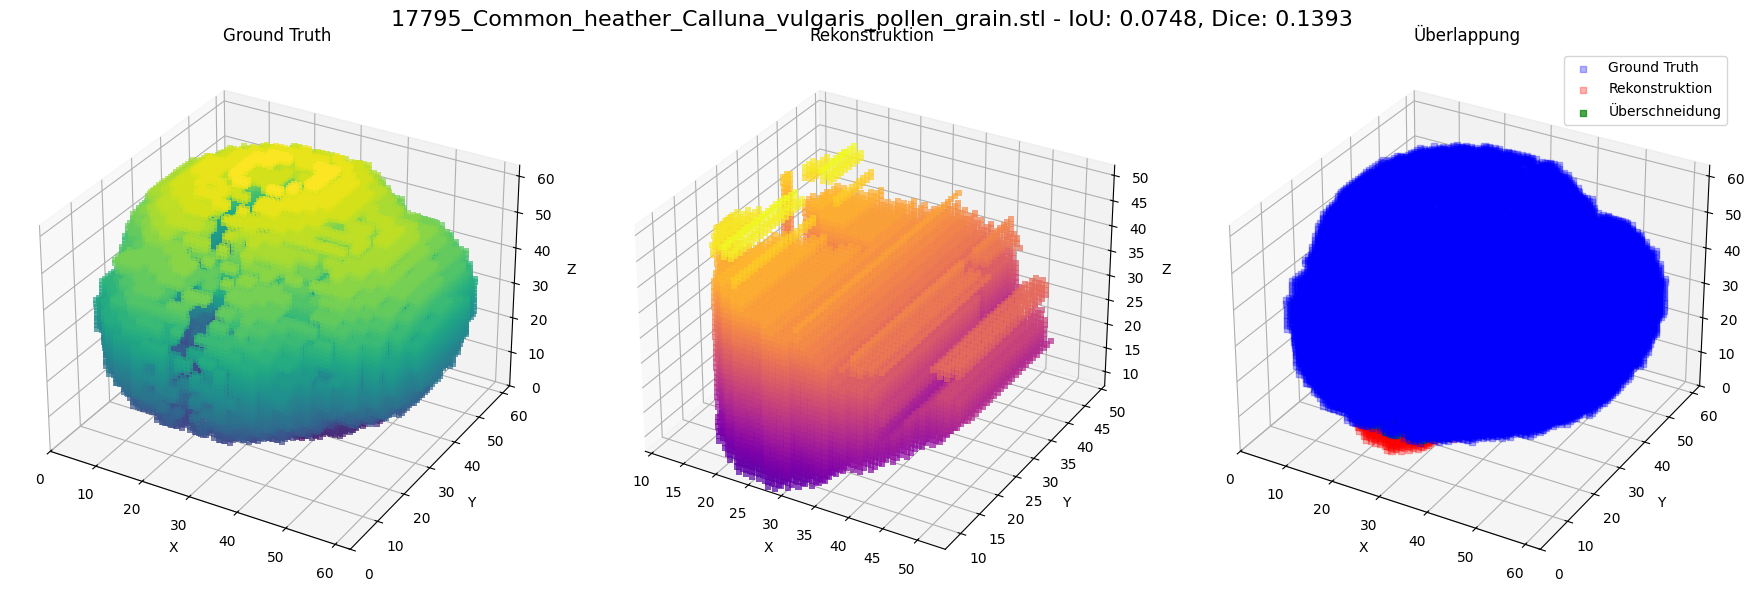

Evaluiere Modelle:  10%|█         | 21/206 [04:05<44:57, 14.58s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17795_Common_heather_Calluna_vulgaris_pollen_grain_vsi.stl gespeichert

Verarbeite 17796_Hardy_fuchsia_Fuchsia_magellanica_pollen_grain.stl (22/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17796_Hardy_fuchsia_Fuchsia_magellanica_pollen_grain.stl
Mesh loaded successfully: 193010 faces, 96503 vertices
Mesh volume: 31612.307169095177
Is watertight: True
Bounding box: [[30.85880089 31.79840088  2.24782991]
 [93.65039825 96.82769775 47.33229828]]
Trying ray-based voxelization...
Voxelized shape: (28, 29, 21), filled voxels: 3735
Resizing voxel grid from (28, 29, 21) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 60722 filled voxels
  IoU: 0.1035, Dice: 0.1875, F1: 0.1875
  Precision: 0.3730, Recall: 0.1253
  Volumenverhältnis: 0.3359 (20394/60722 Voxel)


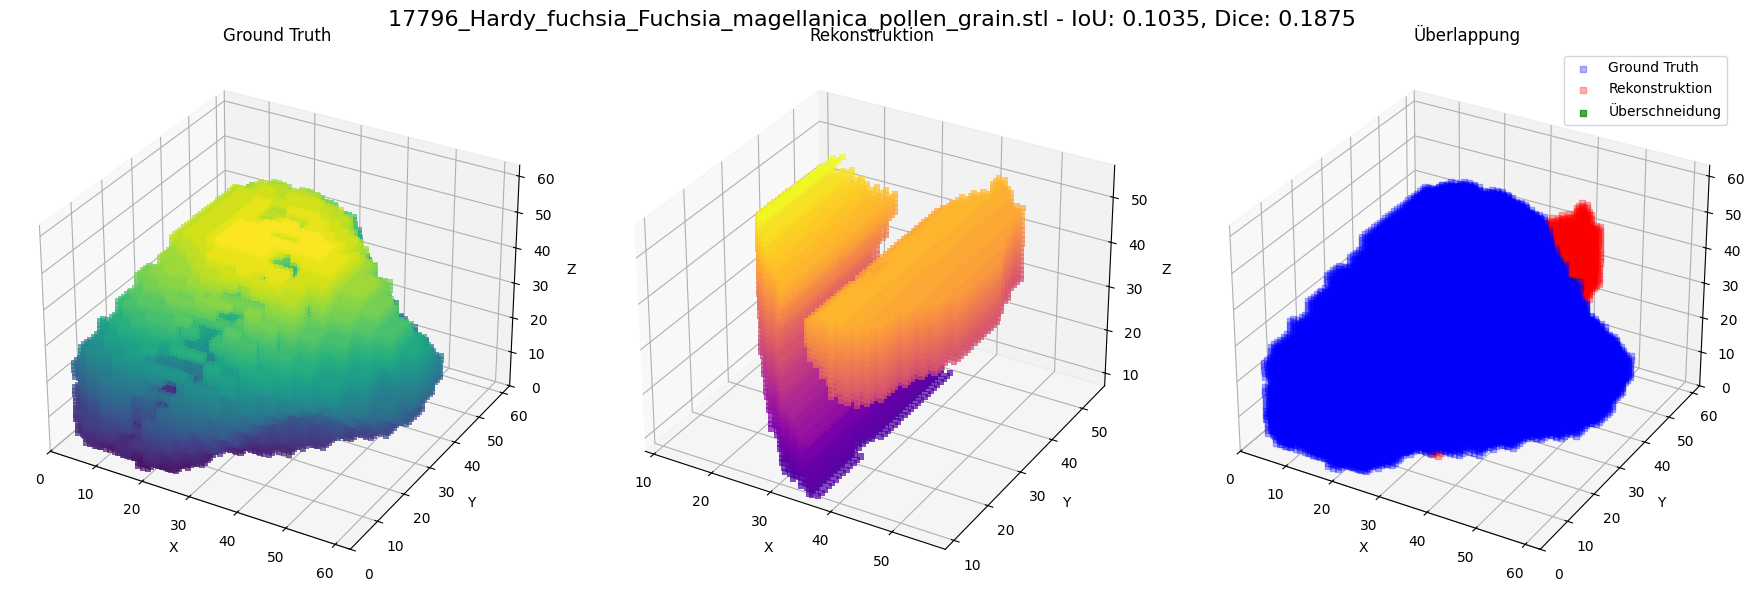

Evaluiere Modelle:  11%|█         | 22/206 [04:21<45:50, 14.95s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17796_Hardy_fuchsia_Fuchsia_magellanica_pollen_grain_vsi.stl gespeichert

Verarbeite 17798_Tomato_Solanum_lycopersicum_pollen_grain.stl (23/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17798_Tomato_Solanum_lycopersicum_pollen_grain.stl
Mesh loaded successfully: 195444 faces, 97732 vertices
Mesh volume: 8901.608049962837
Is watertight: True
Bounding box: [[ 9.92368031 12.35719967  0.372666  ]
 [31.30960083 39.97169876 30.25740051]]
Trying ray-based voxelization...
Voxelized shape: (21, 27, 29), filled voxels: 1778
Resizing voxel grid from (21, 27, 29) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 28719 filled voxels
  IoU: 0.0000, Dice: 0.0000, F1: 0.0000
  Precision: 0.0000, Recall: 0.0000
  Volumenverhältnis: 0.5515 (15839/28719 Voxel)


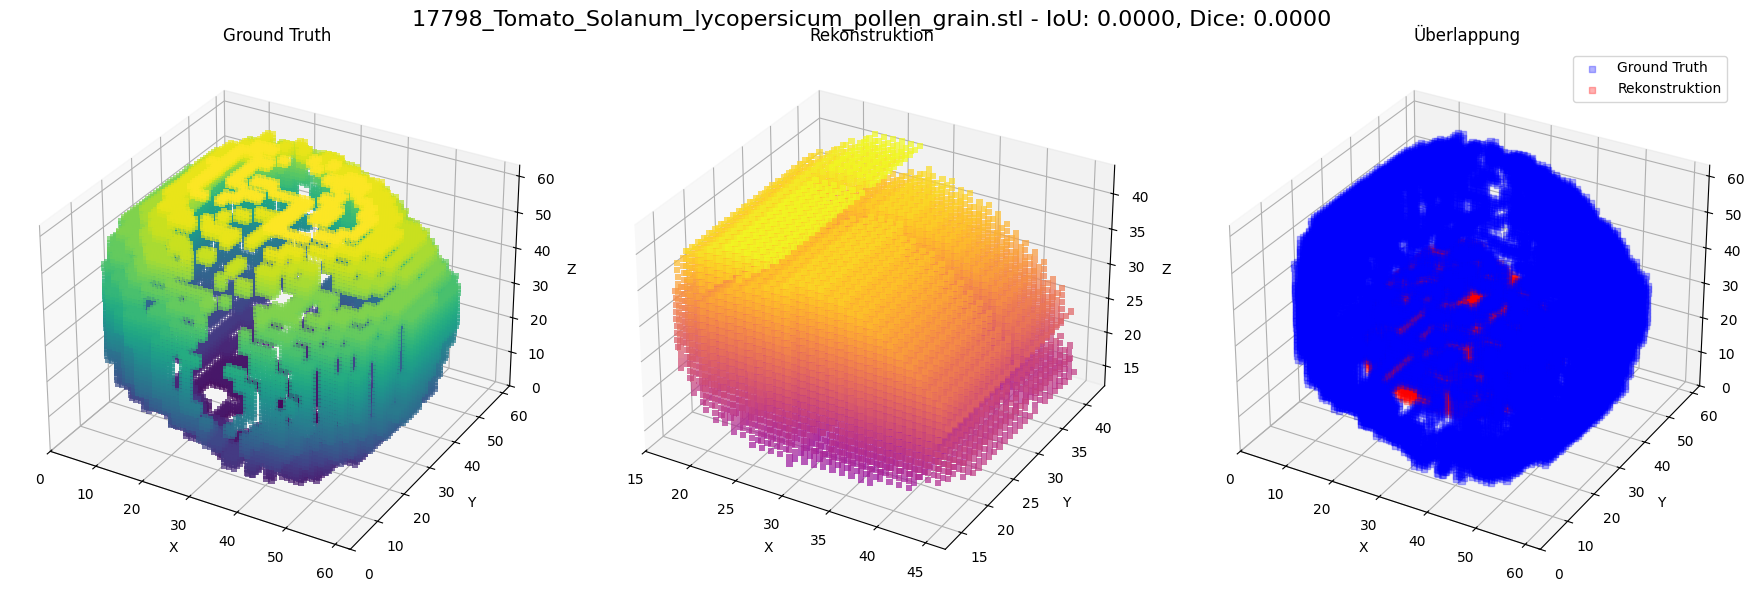

Evaluiere Modelle:  11%|█         | 23/206 [04:25<36:03, 11.82s/it]

Modell als C:/Users/super/Documents/Github/sequoia/data\raw\vsi_evaluation\17798_Tomato_Solanum_lycopersicum_pollen_grain_vsi.stl gespeichert

Verarbeite 17799_Common_thistle_Cirsium_vulgare_pollen_grain.stl (24/206)...
Loading STL file: C:\Users\super\Documents\Github\sequoia\data\raw\17799_Common_thistle_Cirsium_vulgare_pollen_grain.stl
Mesh loaded successfully: 185088 faces, 92556 vertices
Mesh volume: 27036.49108125854
Is watertight: True
Bounding box: [[10.51259995  7.18329     0.105104  ]
 [50.03160095 47.35609818 39.9518013 ]]
Trying ray-based voxelization...
Voxelized shape: (29, 29, 29), filled voxels: 2262
Resizing voxel grid from (29, 29, 29) to (64, 64, 64)
Final voxel grid: shape (64, 64, 64), 24815 filled voxels


In [ ]:
import numpy as np
import trimesh
from skimage import measure
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import os
from sklearn.metrics import precision_recall_fscore_support
from typing import Dict, Union, Optional, Tuple
import torch
# import zoom from scipy.ndimage
from scipy.ndimage import zoom
from scipy.ndimage import binary_dilation, binary_closing

# import traceback
import sys
import traceback
from torch.utils.data import DataLoader
from tqdm import tqdm

from data.dataset import PollenDataset
from torchvision import transforms


class VSIEvaluator:
    """Evaluates the quality of 3D reconstructions compared to ground truth models."""
    
    def __init__(self, resolution: int = 64):
        """
        Initialize the evaluator with specified voxel resolution.
        
        Args:
            resolution: Size of the voxel grid
        """
        self.resolution = resolution
    
        from scipy.ndimage import zoom, binary_dilation, binary_closing
    import sys
    import traceback
    
    def stl_to_voxels(self, stl_path: str) -> np.ndarray:
        """
        Convert an STL file to a voxel grid with the desired resolution.
        
        Args:
            stl_path: Path to the STL file
            
        Returns:
            numpy.ndarray: Boolean voxel grid model
        """
        print(f"Loading STL file: {stl_path}")
        try:
            # Check if file exists
            if not os.path.exists(stl_path):
                print(f"File not found: {stl_path}")
                return np.zeros((self.resolution, self.resolution, self.resolution), dtype=bool)
            
            # Load the mesh
            mesh = trimesh.load(stl_path)
            print(f"Mesh loaded successfully: {len(mesh.faces)} faces, {len(mesh.vertices)} vertices")
            
            # Basic mesh statistics
            print(f"Mesh volume: {mesh.volume if hasattr(mesh, 'volume') else 'N/A'}")
            print(f"Is watertight: {mesh.is_watertight if hasattr(mesh, 'is_watertight') else 'N/A'}")
            print(f"Bounding box: {mesh.bounds if hasattr(mesh, 'bounds') else 'N/A'}")
            
            # Ensure mesh is watertight if possible
            if hasattr(mesh, 'is_watertight') and not mesh.is_watertight:
                print("Mesh is not watertight, attempting repairs...")
                mesh.fill_holes()
                
            # Center and normalize the mesh
            mesh.vertices -= mesh.bounding_box.centroid
            max_dim = np.max(mesh.bounding_box.extents)
            if max_dim <= 0:
                print("Error: Invalid mesh dimensions")
                return np.zeros((self.resolution, self.resolution, self.resolution), dtype=bool)
                
            # Scale to fill most of the voxel grid
            mesh.vertices /= max_dim
            mesh.vertices *= 0.9  # 90% of the grid
            
            # Try multiple voxelization methods
            voxel_grid = None
            
            # Method 1: Use trimesh's voxelization with 'ray' method
            try:
                print("Trying ray-based voxelization...")
                voxel_grid = mesh.voxelized(pitch=2.0/self.resolution, method='ray')
                voxel_grid = voxel_grid.fill()
                voxel_matrix = voxel_grid.matrix
                print(f"Voxelized shape: {voxel_matrix.shape}, filled voxels: {np.sum(voxel_matrix)}")
                
                if np.sum(voxel_matrix) > 0:
                    # Success!
                    pass
                else:
                    # Try with different method
                    raise ValueError("Ray voxelization produced empty grid")
                    
            except Exception as e:
                print(f"Ray voxelization failed: {e}")
                
                # Method 2: Try with 'subdivide' method
                try:
                    print("Trying subdivision voxelization...")
                    voxel_grid = mesh.voxelized(pitch=2.0/self.resolution, method='subdivide')
                    voxel_grid = voxel_grid.fill()
                    voxel_matrix = voxel_grid.matrix
                    print(f"Voxelized shape: {voxel_matrix.shape}, filled voxels: {np.sum(voxel_matrix)}")
                    
                    if np.sum(voxel_matrix) == 0:
                        raise ValueError("Subdivision voxelization produced empty grid")
                    
                except Exception as e2:
                    print(f"Subdivision voxelization failed: {e2}")
                    
                    # Method 3: Point-in-mesh test (manual voxelization)
                    try:
                        print("Trying manual point-in-mesh voxelization...")
                        # Create a grid of points
                        x = np.linspace(-1, 1, self.resolution)
                        y = np.linspace(-1, 1, self.resolution)
                        z = np.linspace(-1, 1, self.resolution)
                        
                        xx, yy, zz = np.meshgrid(x, y, z)
                        points = np.column_stack((xx.flatten(), yy.flatten(), zz.flatten()))
                        
                        # Check which points are inside the mesh
                        inside = mesh.contains(points)
                        voxel_matrix = inside.reshape((self.resolution, self.resolution, self.resolution))
                        print(f"Manual voxelization: {np.sum(voxel_matrix)} filled voxels")
                        
                    except Exception as e3:
                        print(f"Manual voxelization failed: {e3}")
                        
                        # Last resort: Create a spherical placeholder based on the mesh bounding box
                        print("All voxelization methods failed. Creating placeholder model.")
                        center = np.zeros(3)
                        radius = 0.5  # Half of normalized space
                        
                        # Create a simple sphere
                        x = np.linspace(-1, 1, self.resolution)
                        y = np.linspace(-1, 1, self.resolution)
                        z = np.linspace(-1, 1, self.resolution)
                        xx, yy, zz = np.meshgrid(x, y, z)
                        
                        # Calculate distance from center and create sphere
                        dist = np.sqrt((xx - center[0])**2 + (yy - center[1])**2 + (zz - center[2])**2)
                        voxel_matrix = dist <= radius
            
            # Ensure the voxel grid has the correct shape
            if voxel_matrix is None:
                print("Voxelization failed completely")
                return np.zeros((self.resolution, self.resolution, self.resolution), dtype=bool)
                
            if voxel_matrix.shape != (self.resolution, self.resolution, self.resolution):
                print(f"Resizing voxel grid from {voxel_matrix.shape} to ({self.resolution}, {self.resolution}, {self.resolution})")
                
                try:
                    # Calculate scaling factors
                    scale_x = self.resolution / voxel_matrix.shape[0]
                    scale_y = self.resolution / voxel_matrix.shape[1]
                    scale_z = self.resolution / voxel_matrix.shape[2]
                    
                    # Resize using scipy zoom with nearest neighbor interpolation
                    voxel_matrix = zoom(voxel_matrix, (scale_x, scale_y, scale_z), order=0)
                except Exception as resize_error:
                    print(f"Error during resizing: {resize_error}")
                    # Create a new matrix with the right size
                    new_matrix = np.zeros((self.resolution, self.resolution, self.resolution), dtype=bool)
                    
                    # Copy as much as possible from the original
                    min_x = min(voxel_matrix.shape[0], self.resolution)
                    min_y = min(voxel_matrix.shape[1], self.resolution)
                    min_z = min(voxel_matrix.shape[2], self.resolution)
                    new_matrix[:min_x, :min_y, :min_z] = voxel_matrix[:min_x, :min_y, :min_z]
                    voxel_matrix = new_matrix
            
            # Perform post-processing if necessary
            if np.sum(voxel_matrix) < self.resolution:  # Very few voxels filled
                print(f"Only {np.sum(voxel_matrix)} voxels filled. Applying morphological operations...")
                # Apply closing to fill small holes and smooth the surface
                voxel_matrix = binary_closing(voxel_matrix)
                
                # If still too few, apply dilation
                if np.sum(voxel_matrix) < self.resolution:
                    voxel_matrix = binary_dilation(voxel_matrix, iterations=2)
            
            print(f"Final voxel grid: shape {voxel_matrix.shape}, {np.sum(voxel_matrix)} filled voxels")
            return voxel_matrix
            
        except Exception as e:
            print(f"Unexpected error in stl_to_voxels: {e}")
            traceback.print_exc()
            return np.zeros((self.resolution, self.resolution, self.resolution), dtype=bool)
    
    
    def iou_score(self, pred: np.ndarray, target: np.ndarray) -> float:
        """
        Berechnet den Intersection-over-Union-Score (IoU) zwischen zwei Voxel-Gittern.
        
        Args:
            pred: Rekonstruiertes Voxel-Gitter
            target: Ground-Truth-Voxel-Gitter
            
        Returns:
            IoU-Score (0.0 bis 1.0)
        """
        intersection = np.logical_and(pred, target).sum()
        union = np.logical_or(pred, target).sum()
        return float(intersection / union) if union > 0 else 0.0
    
    def dice_coefficient(self, pred: np.ndarray, target: np.ndarray) -> float:
        """
        Berechnet den Dice-Koeffizienten (F1-Score) zwischen zwei Voxel-Gittern.
        
        Args:
            pred: Rekonstruiertes Voxel-Gitter
            target: Ground-Truth-Voxel-Gitter
            
        Returns:
            Dice-Koeffizient (0.0 bis 1.0)
        """
        intersection = np.logical_and(pred, target).sum()
        return float(2 * intersection / (pred.sum() + target.sum())) if (pred.sum() + target.sum()) > 0 else 0.0
    
    def chamfer_distance(self, pred: np.ndarray, target: np.ndarray) -> float:
        """
        Approximiert die Chamfer-Distanz zwischen zwei Voxel-Gittern.
        Eine vereinfachte Version zur Bewertung der Oberflächengenauigkeit.
        
        Args:
            pred: Rekonstruiertes Voxel-Gitter
            target: Ground-Truth-Voxel-Gitter
            
        Returns:
            Chamfer-Distanz (niedrigere Werte sind besser)
        """
        # Oberflächenpunkte extrahieren
        try:
            # Oberflächenpunkte von Vorhersage
            pred_surface = np.array(np.where(pred)).T
            if len(pred_surface) == 0:
                return float('inf')
                
            # Oberflächenpunkte von Ground-Truth
            target_surface = np.array(np.where(target)).T
            if len(target_surface) == 0:
                return float('inf')
            
            # Für jeden Punkt in pred_surface den nächsten Punkt in target_surface finden
            dist_pred_to_target = np.min([np.linalg.norm(p - target_surface, axis=1).min() for p in pred_surface])
            
            # Für jeden Punkt in target_surface den nächsten Punkt in pred_surface finden
            dist_target_to_pred = np.min([np.linalg.norm(p - pred_surface, axis=1).min() for p in target_surface])
            
            # Chamfer-Distanz ist die Summe der durchschnittlichen Abstände in beide Richtungen
            return float(dist_pred_to_target + dist_target_to_pred) / 2.0
        except:
            return float('inf')
    
    def volumetric_error(self, pred: np.ndarray, target: np.ndarray) -> float:
        """
        Berechnet den prozentualen Unterschied im Volumen.
        
        Args:
            pred: Rekonstruiertes Voxel-Gitter
            target: Ground-Truth-Voxel-Gitter
            
        Returns:
            Volumenunterschied in Prozent (0.0 für identische Volumina)
        """
        pred_volume = pred.sum()
        target_volume = target.sum()
        
        if target_volume == 0:
            return float('inf') if pred_volume > 0 else 0.0
            
        return abs(pred_volume - target_volume) / target_volume
    
    def evaluate(self, reconstruction: np.ndarray, ground_truth_path: str) -> Dict:
        """
        Bewertet die Rekonstruktionsqualität im Vergleich zur Ground-Truth.
        
        Args:
            reconstruction: Rekonstruiertes Voxel-Gitter
            ground_truth_path: Pfad zur Ground-Truth-STL-Datei
            
        Returns:
            Dict mit Evaluierungsmetriken
        """
        # Ground-Truth-Modell in Voxel-Gitter umwandeln
        gt_voxels = self.stl_to_voxels(ground_truth_path)
        
        # IoU und Dice-Koeffizient berechnen
        iou = self.iou_score(reconstruction, gt_voxels)
        dice = self.dice_coefficient(reconstruction, gt_voxels)
        
        # Precision, Recall und F1-Score berechnen
        precision, recall, f1, _ = precision_recall_fscore_support(
            gt_voxels.flatten(), reconstruction.flatten(), 
            average='binary', zero_division=0
        )
        
        # Volumen-basierte Metriken
        vol_gt = gt_voxels.sum()
        vol_rec = reconstruction.sum()
        vol_error = self.volumetric_error(reconstruction, gt_voxels)
        vol_ratio = float(vol_rec / vol_gt) if vol_gt > 0 else float('inf')
        
        # Chamfer-Distanz für Oberflächengenauigkeit
        chamfer = self.chamfer_distance(reconstruction, gt_voxels)
        
        return {
            'iou': iou,
            'dice': dice,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'volume_error': vol_error,
            'volume_ratio': vol_ratio,
            'chamfer_distance': chamfer,
            'gt_volume': int(vol_gt),
            'rec_volume': int(vol_rec),
            'gt_voxels': gt_voxels
        }
    
    def visualize_comparison(self, reconstruction: np.ndarray, 
                           ground_truth: np.ndarray, 
                           title: Optional[str] = None) -> None:
        """
        Visualisiert den Vergleich zwischen Rekonstruktion und Ground-Truth.
        
        Args:
            reconstruction: Rekonstruiertes Voxel-Gitter
            ground_truth: Ground-Truth-Voxel-Gitter
            title: Optionaler Titel für den Plot
        """
        fig = plt.figure(figsize=(18, 6))
        
        # 1. Ground-Truth-Visualisierung
        ax1 = fig.add_subplot(131, projection='3d')
        z1, y1, x1 = np.where(ground_truth)
        if len(x1) > 0:
            colors1 = cm.viridis(z1 / float(z1.max() or 1))
            ax1.scatter(x1, y1, z1, c=colors1, marker='s', alpha=0.7, edgecolors='none')
        ax1.set_title("Ground Truth")
        self._set_axes_equal(ax1, x1, y1, z1)
        
        # 2. Rekonstruktions-Visualisierung
        ax2 = fig.add_subplot(132, projection='3d')
        z2, y2, x2 = np.where(reconstruction)
        if len(x2) > 0:
            colors2 = cm.plasma(z2 / float(z2.max() or 1))
            ax2.scatter(x2, y2, z2, c=colors2, marker='s', alpha=0.7, edgecolors='none')
        ax2.set_title("Rekonstruktion")
        self._set_axes_equal(ax2, x2, y2, z2)
        
        # 3. Überlappungs-Visualisierung
        ax3 = fig.add_subplot(133, projection='3d')
        
        # Ground-Truth (blau)
        if len(x1) > 0:
            ax3.scatter(x1, y1, z1, color='blue', marker='s', alpha=0.3, label='Ground Truth')
        
        # Rekonstruktion (rot)
        if len(x2) > 0:
            ax3.scatter(x2, y2, z2, color='red', marker='s', alpha=0.3, label='Rekonstruktion')
        
        # Überschneidung (grün)
        intersection = np.logical_and(ground_truth, reconstruction)
        z3, y3, x3 = np.where(intersection)
        if len(x3) > 0:
            ax3.scatter(x3, y3, z3, color='green', marker='s', alpha=0.7, label='Überschneidung')
        
        ax3.set_title("Überlappung")
        ax3.legend()
        
        # Achsen gleichsetzen für die Überlappungsansicht
        all_x = np.concatenate([x1, x2]) if len(x1) > 0 and len(x2) > 0 else (x1 if len(x1) > 0 else x2)
        all_y = np.concatenate([y1, y2]) if len(y1) > 0 and len(y2) > 0 else (y1 if len(y1) > 0 else y2)
        all_z = np.concatenate([z1, z2]) if len(z1) > 0 and len(z2) > 0 else (z1 if len(z1) > 0 else z2)
        self._set_axes_equal(ax3, all_x, all_y, all_z)
        
        # Gesamttitel
        if title:
            plt.suptitle(title, fontsize=16)
        
        plt.tight_layout()
        plt.show()
    
    def _set_axes_equal(self, ax, x, y, z):
        """
        Setzt die Achsen der 3D-Plots auf gleiche Skalierung.
        
        Args:
            ax: Matplotlib 3D-Achsenobjekt
            x, y, z: Koordinaten für die Achsenlimits
        """
        if len(x) == 0:
            ax.set_xlim(0, self.resolution)
            ax.set_ylim(0, self.resolution)
            ax.set_zlim(0, self.resolution)
            return
            
        x_limits = np.min(x), np.max(x)
        y_limits = np.min(y), np.max(y)
        z_limits = np.min(z), np.max(z)
        
        x_range = abs(x_limits[1] - x_limits[0])
        y_range = abs(y_limits[1] - y_limits[0])
        z_range = abs(z_limits[1] - z_limits[0])
        
        max_range = max(x_range, y_range, z_range) / 2.0
        
        mid_x = (x_limits[1] + x_limits[0]) * 0.5
        mid_y = (y_limits[1] + y_limits[0]) * 0.5
        mid_z = (z_limits[1] + z_limits[0]) * 0.5
        
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')


def evaluate_vsi_reconstructions(data_dir: str, processed_dir: str, output_dir: str, resolution: int = 64, visualize: bool = True):
    """
    Führt die Evaluierung für VSI-Rekonstruktionen durch.
    
    Args:
        data_dir: Verzeichnis mit 3D-STL-Modellen
        processed_dir: Verzeichnis mit verarbeiteten 2D-Bildern
        output_dir: Ausgabeverzeichnis für Evaluierungsergebnisse
        resolution: Auflösung des Voxel-Gitters
        visualize: Ob die Vergleiche visualisiert werden sollen
    """
    # Ausgabeverzeichnis erstellen
    os.makedirs(output_dir, exist_ok=True)
    
    # Transformationen für die Bilder
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Resize((resolution, resolution), antialias=True)
    ])
    
    # Dataset und DataLoader initialisieren
    dataset = PollenDataset(data_dir=data_dir, processed_dir=processed_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # VSI-Modell und Evaluator initialisieren
    
    vsi = VoxelSilhouetteIntersection(resolution=resolution)
    evaluator = VSIEvaluator(resolution=resolution)
    
    # Ergebnisse speichern
    all_metrics = []
    
    # Jede Probe verarbeiten
    for i, sample in enumerate(tqdm(dataloader, desc="Evaluiere Modelle")):
        left_view = sample['left_view']
        right_view = sample['right_view']
        file_name = sample['file_name'][0]
        gt_path = sample['3d_model_path'][0]
        
        print(f"\nVerarbeite {file_name} ({i+1}/{len(dataset)})...")
        
        # 3D-Voxel-Modell aus Silhouetten erstellen
        voxel_model = vsi.create_voxel_model(left_view, right_view)
        
        # Rekonstruktion mit Ground-Truth vergleichen
        metrics = evaluator.evaluate(voxel_model, gt_path)
        
        # Dateinamen zu Metriken hinzufügen
        metrics['filename'] = file_name
        all_metrics.append(metrics)
        
        # Metriken ausgeben
        print(f"  IoU: {metrics['iou']:.4f}, Dice: {metrics['dice']:.4f}, F1: {metrics['f1']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")
        print(f"  Volumenverhältnis: {metrics['volume_ratio']:.4f} ({metrics['rec_volume']}/{metrics['gt_volume']} Voxel)")
        
        # Vergleich visualisieren
        if visualize:
            evaluator.visualize_comparison(
                voxel_model, 
                metrics['gt_voxels'],
                f"{file_name} - IoU: {metrics['iou']:.4f}, Dice: {metrics['dice']:.4f}"
            )
        
        # Rekonstruktion speichern
        base_name = os.path.splitext(file_name)[0]
        stl_path = os.path.join(output_dir, f"{base_name}_vsi.stl")
        vsi.save_voxel_model_as_stl(voxel_model, stl_path)
    
    # Durchschnittliche Metriken berechnen
    if all_metrics:
        metrics_df = pd.DataFrame([
            {k: v for k, v in m.items() if k not in ['gt_voxels']}
            for m in all_metrics
        ])
        
        # Durchschnittliche Metriken ausgeben
        avg_metrics = metrics_df.mean(numeric_only=True)
        print("\nDurchschnittliche Metriken über alle Modelle:")
        print(f"  IoU: {avg_metrics['iou']:.4f}")
        print(f"  Dice-Koeffizient: {avg_metrics['dice']:.4f}")
        print(f"  F1-Score: {avg_metrics['f1']:.4f}")
        print(f"  Precision: {avg_metrics['precision']:.4f}")
        print(f"  Recall: {avg_metrics['recall']:.4f}")
        
        # Metriken als CSV speichern
        csv_path = os.path.join(output_dir, "vsi_reconstruction_metrics.csv")
        metrics_df.to_csv(csv_path, index=False)
        print(f"\nMetriken gespeichert in {csv_path}")
        
        # Vergleichsdiagramm der Metriken über alle Modelle
        plt.figure(figsize=(12, 8))
        metrics_df[['iou', 'dice', 'precision', 'recall', 'f1']].plot(kind='bar')
        plt.title('Vergleich der Rekonstruktionsmetriken')
        plt.ylabel('Score')
        plt.xlabel('Modellindex')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "vsi_metrics_comparison.png"), dpi=300)
        plt.show()


if __name__ == "__main__":
    # Konfiguration
    data_dir = os.path.join(os.getenv("DATA_DIR_PATH"), 'raw')
    processed_dir = os.getenv("DATA_DIR_PATH_PROCESSED")
    output_dir = os.path.join(data_dir, "vsi_evaluation")
    resolution = 64
    
    # Evaluierung durchführen
    evaluate_vsi_reconstructions(data_dir, processed_dir, output_dir, resolution)